### Load the Libraries

In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

### Load the datasets

In [2]:
# Path to the folder containing CSV files
folder_path = 'raw_soccer_files'

# List all files in the folder
file_list = os.listdir(folder_path)

# Create separate dataframes and name them with their original names
for file_name in file_list:
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        
        # Use the original file name (without extension) as the dataframe name
        df_name = os.path.splitext(file_name)[0]
        
        # Create a variable with the dataframe name and store the dataframe in it
        locals()[df_name] = df


### Info for each datasets

#### 01) Player salary dataset

In [3]:
player_salary_data

,player_id,team_id,season_name,position,base_salary,guaranteed_compensation,mlspa_release,competition
0,0Oq6006M6D,mKAqBBmqbg,2013,D,200000.0,200000.0,2013-05-01,mls
1,0Oq6006M6D,mKAqBBmqbg,2013,D,200000.0,200000.0,2013-08-01,mls
2,0Oq6006M6D,mKAqBBmqbg,2013,D,200000.0,200000.0,2013-09-15,mls
3,0Oq60APM6D,0KPqjA456v,2013,D,205000.0,208333.0,2013-05-01,mls
4,0Oq60APM6D,0KPqjA456v,2013,D,205000.0,208333.0,2013-08-01,mls
...,...,...,...,...,...,...,...,...
13273,zeQZzPgQKw,0KPqjA456v,2020,F,525000.0,574667.0,2020-12-01,mls
13274,zeQZzPgQKw,gpMOLwl5zy,2021,F,650000.0,716667.0,2021-04-15,mls
13275,zeQZzPgQKw,gpMOLwl5zy,2021,F,650000.0,716667.0,2021-09-30,mls
13276,zeQZzPgQKw,gpMOLwl5zy,2022,F,650000.0,716667.0,2022-04-15,mls


In [4]:
# Drop 'mlspa_release' column from the dataset. 
# It creates same data row in multiple times. Therefore, its worth to remove that column from the dataset
player_salary_data = player_salary_data.drop(columns = ['mlspa_release','competition','guaranteed_compensation'])

In [5]:
# Drop all the duplicates
player_salary_data = player_salary_data.drop_duplicates()
player_salary_data.shape

(7561, 5)

In [6]:
player_salary_data.dtypes

player_id       object
team_id         object
season_name      int64
position        object
base_salary    float64
dtype: object

In [7]:
# Check for the missing values
player_salary_data.isna().sum()

player_id       0
team_id        98
season_name     0
position       18
base_salary     0
dtype: int64

In [8]:
# Drop all the missing values
player_salary_data = player_salary_data.dropna()
player_salary_data.isna().sum()

player_id      0
team_id        0
season_name    0
position       0
base_salary    0
dtype: int64

In [9]:
player_salary_data.shape

(7447, 5)

#### 02) Game Info dataset

In [10]:
game_info

,game_id,date,season_name
0,NPqxxL8Xq9,2013-03-02,2013
1,9vQ2ZGnmQK,2013-03-02,2013
2,kRQaolgj5K,2013-03-03,2013
3,KPqjK3VYQ6,2013-03-03,2013
4,aDQ0NW635E,2013-03-03,2013
...,...,...,...
3890,EGMP0bykMa,2022-10-23,2022
3891,Pk5L08V75O,2022-10-24,2022
3892,gjMNAbLjQK,2022-10-30,2022
3893,raMyEd8eMd,2022-10-31,2022


In [11]:
game_info.dtypes

game_id        object
date           object
season_name     int64
dtype: object

In [12]:
game_info.isna().sum() # No missing values

game_id        0
date           0
season_name    0
dtype: int64

In [13]:
game_info.duplicated().sum() # No duplicates

0

#### 03) Player Info dataset

In [14]:
player_info

,player_id,player_name,birth_date,height_ft,height_in,nationality,weight_lb
0,p6qbOXVXQ0,A.J. Cochran,1993-02-09,6.0,3.0,USA,196.0
1,315VDkYQ9x,A.J. DeLaGarza,1987-11-04,5.0,9.0,USA,152.0
2,Oa5wV7E9M1,A.J. Palazzolo,1998-02-18,6.0,1.0,USA,165.0
3,wvq9eEX3qW,A.J. Paterson,1996-01-31,6.0,2.0,USA,187.0
4,4wM42Jezqj,A.J. Soares,1988-11-28,6.0,0.0,USA,172.0
...,...,...,...,...,...,...,...
6206,Vj58WVR4M8,NaN,NaN,NaN,NaN,NaN,NaN
6207,wvq9XOwl5W,NaN,NaN,NaN,NaN,NaN,NaN
6208,XVqK29oK50,NaN,NaN,NaN,NaN,NaN,NaN
6209,xW5pw0L6Mg,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
player_info.dtypes

player_id       object
player_name     object
birth_date      object
height_ft      float64
height_in      float64
nationality     object
weight_lb      float64
dtype: object

In [16]:
# Check for the missing values
player_info.isna().sum()

player_id         0
player_name      34
birth_date      122
height_ft       833
height_in       833
nationality      60
weight_lb      1344
dtype: int64

In [17]:
# Drop all the missing values
player_info = player_info.dropna()
player_info.isna().sum()

player_id      0
player_name    0
birth_date     0
height_ft      0
height_in      0
nationality    0
weight_lb      0
dtype: int64

In [18]:
player_info.duplicated().sum() # No duplicates

0

In [19]:
player_info['height'] = (player_info['height_ft'] * 12) + player_info['height_in']
player_info = player_info.drop(columns = ['height_ft','height_in'])
player_info

/var/folders/27/gbz_5drj4l13l6x8mnk54j1w0000gn/T/ipykernel_4753/2084534887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_info['height'] = (player_info['height_ft'] * 12) + player_info['height_in']


,player_id,player_name,birth_date,nationality,weight_lb,height
0,p6qbOXVXQ0,A.J. Cochran,1993-02-09,USA,196.0,75.0
1,315VDkYQ9x,A.J. DeLaGarza,1987-11-04,USA,152.0,69.0
2,Oa5wV7E9M1,A.J. Palazzolo,1998-02-18,USA,165.0,73.0
3,wvq9eEX3qW,A.J. Paterson,1996-01-31,USA,187.0,74.0
4,4wM42Jezqj,A.J. Soares,1988-11-28,USA,172.0,72.0
...,...,...,...,...,...,...
6166,eV5DzA1nQK,Zion Scarlett,2004-05-05,USA,170.0,74.0
6167,gpMOoayMzy,Zlatan Ibrahimovic,1981-10-03,Sweden,209.0,77.0
6172,raMyRP25d2,Zoltán Stieber,1988-10-16,Hungary,148.0,69.0
6174,N6MmW4dPqE,Zoumana Diarra,2003-04-27,Ivory Coast,150.0,67.0


In [20]:
player_info.shape

(4851, 6)

#### 04) Player passing data

In [21]:
player_passing_data

,player_id,game_id,team_id,general_position,minutes_played,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,passes_completed_over_expected_p100,avg_distance_yds,avg_vertical_distance_yds,share_team_touches,competition
0,0Oq60APM6D,0Oq6Y1ax56,Vj58weDM8n,CB,101,37,0.8649,0.8301,1.2881,3.4812,21.7536,9.4829,0.0889,mls
1,0Oq60APM6D,0Oq6YPW756,Vj58weDM8n,FB,96,54,0.7037,0.7603,-3.0555,-5.6583,23.2053,11.4738,0.1115,mls
2,0Oq60APM6D,0x5gbdYjM7,Vj58weDM8n,FB,96,41,0.8780,0.8336,1.8213,4.4422,18.2548,2.3546,0.0748,mls
3,0Oq60APM6D,0x5gk42R57,0KPqjA456v,CB,95,60,0.8000,0.8181,-1.0877,-1.8128,26.3321,14.4037,0.1106,mls
4,0Oq60APM6D,0x5gLxnPq7,0KPqjA456v,CB,95,31,0.6774,0.7482,-2.1930,-7.0742,25.1257,14.7807,0.0801,mls
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110752,zeQZzPgQKw,xW5pLV665g,0KPqjA456v,ST,70,19,0.5263,0.6053,-1.5016,-7.9030,18.1320,2.9161,0.0547,mls
110753,zeQZzPgQKw,xW5pXj195g,gpMOLwl5zy,ST,73,11,0.7273,0.7977,-0.7745,-7.0409,19.8733,3.6992,0.0248,mls
110754,zeQZzPgQKw,zeQZZ64KQK,0KPqjA456v,ST,38,9,0.5556,0.6353,-0.7180,-7.9777,12.8088,3.6647,0.0191,mls
110755,zeQZzPgQKw,zeQZZ6exQK,0KPqjA456v,ST,99,24,0.7083,0.6623,1.1058,4.6074,14.7522,0.3574,0.0577,mls


In [22]:
player_passing_data = player_passing_data.drop(columns = ['competition'])

In [23]:
player_passing_data.dtypes

player_id                               object
game_id                                 object
team_id                                 object
general_position                        object
minutes_played                           int64
attempted_passes                         int64
pass_completion_percentage             float64
xpass_completion_percentage            float64
passes_completed_over_expected         float64
passes_completed_over_expected_p100    float64
avg_distance_yds                       float64
avg_vertical_distance_yds              float64
share_team_touches                     float64
dtype: object

In [24]:
player_passing_data.isna().sum() # No missing values

player_id                              0
game_id                                0
team_id                                0
general_position                       0
minutes_played                         0
attempted_passes                       0
pass_completion_percentage             0
xpass_completion_percentage            0
passes_completed_over_expected         0
passes_completed_over_expected_p100    0
avg_distance_yds                       0
avg_vertical_distance_yds              0
share_team_touches                     0
dtype: int64

In [25]:
player_passing_data['minutes_played'] = player_passing_data['minutes_played'].astype(float)

# List of columns to be transformed
quantitative_columns = [
    'attempted_passes',
    'pass_completion_percentage',
    'xpass_completion_percentage',
    'passes_completed_over_expected',
    'passes_completed_over_expected_p100',
    'avg_distance_yds',
    'avg_vertical_distance_yds',
    'share_team_touches'
]

# Iterate through each row and update the values in the quantitative columns
for col in quantitative_columns:
    player_passing_data[col] = (player_passing_data[col] / player_passing_data['minutes_played']) * 90

player_passing_data

,player_id,game_id,team_id,general_position,minutes_played,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,passes_completed_over_expected_p100,avg_distance_yds,avg_vertical_distance_yds,share_team_touches
0,0Oq60APM6D,0Oq6Y1ax56,Vj58weDM8n,CB,101.0,32.970297,0.770703,0.739693,1.147812,3.102059,19.384396,8.450109,0.079218
1,0Oq60APM6D,0Oq6YPW756,Vj58weDM8n,FB,96.0,50.625000,0.659719,0.712781,-2.864531,-5.304656,21.754969,10.756687,0.104531
2,0Oq60APM6D,0x5gbdYjM7,Vj58weDM8n,FB,96.0,38.437500,0.823125,0.781500,1.707469,4.164562,17.113875,2.207438,0.070125
3,0Oq60APM6D,0x5gk42R57,0KPqjA456v,CB,95.0,56.842105,0.757895,0.775042,-1.030453,-1.717389,24.946200,13.645611,0.104779
4,0Oq60APM6D,0x5gLxnPq7,0KPqjA456v,CB,95.0,29.368421,0.641747,0.708821,-2.077579,-6.701874,23.803295,14.002768,0.075884
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110752,zeQZzPgQKw,xW5pLV665g,0KPqjA456v,ST,70.0,24.428571,0.676671,0.778243,-1.930629,-10.161000,23.312571,3.749271,0.070329
110753,zeQZzPgQKw,xW5pXj195g,gpMOLwl5zy,ST,73.0,13.561644,0.896671,0.983466,-0.954863,-8.680562,24.501329,4.560658,0.030575
110754,zeQZzPgQKw,zeQZZ64KQK,0KPqjA456v,ST,38.0,21.315789,1.315895,1.504658,-1.700526,-18.894553,30.336632,8.679553,0.045237
110755,zeQZzPgQKw,zeQZZ6exQK,0KPqjA456v,ST,99.0,21.818182,0.643909,0.602091,1.005273,4.188545,13.411091,0.324909,0.052455


In [26]:
player_passing_data.duplicated().sum() # No duplicates

0

#### 05) Team Info dataset

In [27]:
team_info

,team_id,team_name,team_short_name,team_abbreviation
0,kRQa8JOqKZ,Angel City FC,Angel City,LA
1,wvq9jx1QWn,Atlanta United 2,Atlanta,ATL
2,KAqBN0Vqbg,Atlanta United FC,Atlanta,ATL
3,0x5gJawM7O,Austin Bold FC,Austin,ATX
4,gpMOLwl5zy,Austin FC,Austin,ATX
...,...,...,...,...
116,eV5D2w9QKn,Utah Royals FC,Utah Royals,UTA
117,lgpMOvnQzy,Vancouver Whitecaps FC,Vancouver,VAN
118,N6MmWV0qEG,Vancouver Whitecaps FC 2,Vancouver,VAN
119,aDQ0lzvQEv,Washington Spirit,Washington,WAS


In [28]:
team_info.dtypes

team_id              object
team_name            object
team_short_name      object
team_abbreviation    object
dtype: object

In [29]:
team_info.isna().sum() # No missing values

team_id              0
team_name            0
team_short_name      0
team_abbreviation    0
dtype: int64

In [30]:
team_info.duplicated().sum() # No duplicates

0

#### 06) player ga avg dataset

In [31]:
player_ga_avg

,player_id,season_name,general_position,team_id,minutes_played,goals_added_above_avg_Dribbling,goals_added_above_avg_Fouling,goals_added_above_avg_Interrupting,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting,offensive_goals_added
0,0Oq60APM6D,2013,CB,0KPqjA456v,1809,0.1379,0.15160,-1.1726,-0.5952,-0.4026,-0.2029,86,22,387,515,334,0,-0.91120
1,0Oq60APM6D,2013,CM,0KPqjA456v,8,-0.0008,0.00001,-0.0013,-0.0026,-0.0037,-0.0021,0,0,2,0,0,0,-0.00919
2,0Oq60APM6D,2014,CB,0KPqjA456v,1868,-0.0374,-0.54960,0.0349,-0.0201,-0.3859,-0.2096,111,31,356,603,418,0,-1.20260
3,0Oq60APM6D,2015,CB,Vj58weDM8n,2474,-0.0264,0.17760,-1.6048,-0.0460,-0.3216,-0.1946,223,49,469,953,651,3,-0.41100
4,0Oq60APM6D,2016,CB,Vj58weDM8n,1546,0.0340,-0.17920,-0.1523,-0.1411,-0.3398,-0.1734,170,30,231,734,524,0,-0.79950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14498,zeQZzPgQKw,2020,ST,0KPqjA456v,125,-0.2053,-0.01190,-0.0415,-0.0250,0.0934,0.0073,26,2,0,36,40,4,-0.14150
14499,zeQZzPgQKw,2020,W,0KPqjA456v,182,0.0119,-0.02040,-0.0774,-0.0544,-0.0488,0.0463,32,2,15,43,48,8,-0.06540
14500,zeQZzPgQKw,2021,ST,gpMOLwl5zy,329,0.0123,-0.04810,-0.0857,-0.0708,-0.2288,-0.2152,20,2,13,41,38,6,-0.55060
14501,zeQZzPgQKw,2022,ST,gpMOLwl5zy,462,0.1548,-0.06770,-0.0690,-0.2068,0.4371,0.0511,38,3,13,61,72,12,0.36850


In [32]:
player_ga_avg.dtypes

player_id                              object
season_name                             int64
general_position                       object
team_id                                object
minutes_played                          int64
goals_added_above_avg_Dribbling       float64
goals_added_above_avg_Fouling         float64
goals_added_above_avg_Interrupting    float64
goals_added_above_avg_Passing         float64
goals_added_above_avg_Receiving       float64
goals_added_above_avg_Shooting        float64
count_actions_Dribbling                 int64
count_actions_Fouling                   int64
count_actions_Interrupting              int64
count_actions_Passing                   int64
count_actions_Receiving                 int64
count_actions_Shooting                  int64
offensive_goals_added                 float64
dtype: object

In [33]:
player_ga_avg.isna().sum() # No missing values

player_id                             0
season_name                           0
general_position                      0
team_id                               0
minutes_played                        0
goals_added_above_avg_Dribbling       0
goals_added_above_avg_Fouling         0
goals_added_above_avg_Interrupting    0
goals_added_above_avg_Passing         0
goals_added_above_avg_Receiving       0
goals_added_above_avg_Shooting        0
count_actions_Dribbling               0
count_actions_Fouling                 0
count_actions_Interrupting            0
count_actions_Passing                 0
count_actions_Receiving               0
count_actions_Shooting                0
offensive_goals_added                 0
dtype: int64

In [34]:
player_ga_avg['minutes_played'] = player_ga_avg['minutes_played'].astype(float)

# List of columns to be transformed
quantitative_columns = [
 'goals_added_above_avg_Dribbling',
 'goals_added_above_avg_Fouling',
 'goals_added_above_avg_Interrupting',
 'goals_added_above_avg_Passing',
 'goals_added_above_avg_Receiving',
 'goals_added_above_avg_Shooting',
 'count_actions_Dribbling',
 'count_actions_Fouling',
 'count_actions_Interrupting',
 'count_actions_Passing',
 'count_actions_Receiving',
 'count_actions_Shooting',
 'offensive_goals_added']

# Iterate through each row and update the values in the quantitative columns
for col in quantitative_columns:
    player_ga_avg[col] = (player_ga_avg[col] / player_ga_avg['minutes_played']) * 90

player_ga_avg

,player_id,season_name,general_position,team_id,minutes_played,goals_added_above_avg_Dribbling,goals_added_above_avg_Fouling,goals_added_above_avg_Interrupting,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting,offensive_goals_added
0,0Oq60APM6D,2013,CB,0KPqjA456v,1809.0,0.006861,0.007542,-0.058338,-0.029612,-0.020030,-0.010095,4.278607,1.094527,19.253731,25.621891,16.616915,0.000000,-0.045333
1,0Oq60APM6D,2013,CM,0KPqjA456v,8.0,-0.009000,0.000111,-0.014625,-0.029250,-0.041625,-0.023625,0.000000,0.000000,22.500000,0.000000,0.000000,0.000000,-0.103389
2,0Oq60APM6D,2014,CB,0KPqjA456v,1868.0,-0.001802,-0.026480,0.001681,-0.000968,-0.018593,-0.010099,5.347966,1.493576,17.152034,29.052463,20.139186,0.000000,-0.057941
3,0Oq60APM6D,2015,CB,Vj58weDM8n,2474.0,-0.000960,0.006461,-0.058380,-0.001673,-0.011699,-0.007079,8.112369,1.782538,17.061439,34.668553,23.682296,0.109135,-0.014951
4,0Oq60APM6D,2016,CB,Vj58weDM8n,1546.0,0.001979,-0.010432,-0.008866,-0.008214,-0.019781,-0.010094,9.896507,1.746442,13.447607,42.729625,30.504528,0.000000,-0.046543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14498,zeQZzPgQKw,2020,ST,0KPqjA456v,125.0,-0.147816,-0.008568,-0.029880,-0.018000,0.067248,0.005256,18.720000,1.440000,0.000000,25.920000,28.800000,2.880000,-0.101880
14499,zeQZzPgQKw,2020,W,0KPqjA456v,182.0,0.005885,-0.010088,-0.038275,-0.026901,-0.024132,0.022896,15.824176,0.989011,7.417582,21.263736,23.736264,3.956044,-0.032341
14500,zeQZzPgQKw,2021,ST,gpMOLwl5zy,329.0,0.003365,-0.013158,-0.023444,-0.019368,-0.062590,-0.058869,5.471125,0.547112,3.556231,11.215805,10.395137,1.641337,-0.150620
14501,zeQZzPgQKw,2022,ST,gpMOLwl5zy,462.0,0.030156,-0.013188,-0.013442,-0.040286,0.085149,0.009955,7.402597,0.584416,2.532468,11.883117,14.025974,2.337662,0.071786


In [35]:
player_ga_avg.duplicated().sum() # No duplicates

0

### Create a single dataframe

In [36]:
merged_df_1 = pd.merge(player_salary_data, player_info, on='player_id', how='inner')
merged_df_1

,player_id,team_id,season_name,position,base_salary,player_name,birth_date,nationality,weight_lb,height
0,0Oq6006M6D,mKAqBBmqbg,2013,D,200000.0,Ugo Ihemelu,1983-04-03,USA,179.0,72.0
1,0Oq60APM6D,0KPqjA456v,2013,D,205000.0,Jason Hernandez,1983-08-26,USA,172.0,71.0
2,0Oq60APM6D,0KPqjA456v,2014,D,210000.0,Jason Hernandez,1983-08-26,USA,172.0,71.0
3,0Oq60APM6D,Vj58weDM8n,2015,D,175000.0,Jason Hernandez,1983-08-26,USA,172.0,71.0
4,0Oq60APM6D,Vj58weDM8n,2016,D,200000.0,Jason Hernandez,1983-08-26,USA,172.0,71.0
...,...,...,...,...,...,...,...,...,...,...
7189,zeQZzPgQKw,0KPqjA456v,2018,F,465000.0,Danny Hoesen,1991-01-15,Netherlands,165.0,73.0
7190,zeQZzPgQKw,0KPqjA456v,2019,F,500000.0,Danny Hoesen,1991-01-15,Netherlands,165.0,73.0
7191,zeQZzPgQKw,0KPqjA456v,2020,F,525000.0,Danny Hoesen,1991-01-15,Netherlands,165.0,73.0
7192,zeQZzPgQKw,gpMOLwl5zy,2021,F,650000.0,Danny Hoesen,1991-01-15,Netherlands,165.0,73.0


In [37]:
# sample = merged_df_1[merged_df_1['player_id']=='Oa5wY8RXQ1']
# sample

In [38]:
merged_df_2 = pd.merge(merged_df_1, team_info, on='team_id', how='inner')
merged_df_2

,player_id,team_id,season_name,position,base_salary,player_name,birth_date,nationality,weight_lb,height,team_name,team_short_name,team_abbreviation
0,0Oq6006M6D,mKAqBBmqbg,2013,D,200000.0,Ugo Ihemelu,1983-04-03,USA,179.0,72.0,FC Dallas,Dallas,FCD
1,0Oq63n7Q6D,mKAqBBmqbg,2013,F,237276.0,Eric Hassli,1981-05-03,France,201.0,76.0,FC Dallas,Dallas,FCD
2,0Oq63P32Q6,mKAqBBmqbg,2020,D,63547.0,Nkosi Burgess,1997-03-23,USA,185.0,76.0,FC Dallas,Dallas,FCD
3,0Oq63P32Q6,mKAqBBmqbg,2021,D,66724.0,Nkosi Burgess,1997-03-23,USA,185.0,76.0,FC Dallas,Dallas,FCD
4,0Oq63P32Q6,mKAqBBmqbg,2022,D,197950.0,Nkosi Burgess,1997-03-23,USA,185.0,76.0,FC Dallas,Dallas,FCD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7189,Vj58B64EQ8,NPqxKXZ59d,2022,GK,180000.0,Pablo Sisniega,1995-07-07,Mexico,176.0,75.0,Charlotte FC,Charlotte,CLT
7190,Vj58WX4JM8,NPqxKXZ59d,2022,M,65500.0,Quinn McNeill,1998-08-30,USA,161.0,71.0,Charlotte FC,Charlotte,CLT
7191,Xj5Y6AlAqb,NPqxKXZ59d,2022,F,84000.0,Orrin McKinze Gaines II,1998-03-02,USA,163.0,71.0,Charlotte FC,Charlotte,CLT
7192,Xj5Y87GAMb,NPqxKXZ59d,2022,M,797500.0,Yordy Reyna,1993-09-17,Peru,150.0,67.0,Charlotte FC,Charlotte,CLT


In [39]:
# sample = merged_df_2[merged_df_2['player_id']=='Oa5wY8RXQ1']
# sample

In [40]:
merged_df_3 = pd.merge(merged_df_2, player_ga_avg, on=['player_id', 'team_id', 'season_name'], how='inner')
merged_df_3

,player_id,team_id,season_name,position,base_salary,player_name,birth_date,nationality,weight_lb,height,...,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting,offensive_goals_added
0,0Oq63n7Q6D,mKAqBBmqbg,2013,F,237276.0,Eric Hassli,1981-05-03,France,201.0,76.0,...,-0.141187,0.113062,0.027750,1.875000,5.625000,3.750000,24.375000,16.875000,3.750000,0.008062
1,0Oq63n7Q6D,mKAqBBmqbg,2013,F,237276.0,Eric Hassli,1981-05-03,France,201.0,76.0,...,0.062391,-0.042310,-0.034975,11.850534,2.882562,3.843416,22.099644,28.505338,2.241993,-0.147875
2,0Oq63n7Q6D,mKAqBBmqbg,2013,F,237276.0,Eric Hassli,1981-05-03,France,201.0,76.0,...,-0.038488,0.051724,0.053153,8.470588,2.117647,3.705882,24.882353,26.470588,3.705882,-0.044894
3,0Oq63P32Q6,mKAqBBmqbg,2021,D,66724.0,Nkosi Burgess,1997-03-23,USA,185.0,76.0,...,0.002564,-0.013662,-0.005151,8.177618,0.646817,14.229979,47.171458,39.871663,0.369610,-0.006459
4,0Oq63P32Q6,mKAqBBmqbg,2021,D,66724.0,Nkosi Burgess,1997-03-23,USA,185.0,76.0,...,-0.039836,-0.020066,-0.010328,11.803279,1.475410,25.081967,42.786885,29.508197,0.000000,-0.016230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14434,Xj5Y87GAMb,NPqxKXZ59d,2022,M,797500.0,Yordy Reyna,1993-09-17,Peru,150.0,67.0,...,-0.025089,-0.105842,-0.046110,16.643836,2.465753,4.931507,14.794521,20.342466,1.232877,-0.160089
14435,Xj5Y87GAMb,NPqxKXZ59d,2022,M,797500.0,Yordy Reyna,1993-09-17,Peru,150.0,67.0,...,0.054429,-0.007205,0.026036,19.955357,3.080357,7.232143,33.214286,30.000000,2.410714,0.055299
14436,zeQZJm9jQK,NPqxKXZ59d,2022,D,325000.0,Anton Walkes,1997-02-08,England,181.0,74.0,...,-0.004342,-0.019726,-0.006532,12.247423,0.417526,11.180412,56.134021,44.628866,0.185567,-0.016279
14437,zeQZJm9jQK,NPqxKXZ59d,2022,D,325000.0,Anton Walkes,1997-02-08,England,181.0,74.0,...,-0.006000,-0.019667,-0.010333,6.666667,1.666667,10.000000,35.000000,28.333333,0.000000,-0.058833


In [41]:
# sample = merged_df_3[merged_df_3['player_id']=='Oa5wY8RXQ1']
# sample

In [42]:
merged_df_4 = pd.merge(player_passing_data, game_info, on='game_id', how='inner')
merged_df_4

,player_id,game_id,team_id,general_position,minutes_played,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,passes_completed_over_expected_p100,avg_distance_yds,avg_vertical_distance_yds,share_team_touches,date,season_name
0,0Oq60APM6D,0Oq6Y1ax56,Vj58weDM8n,CB,101.0,32.970297,0.770703,0.739693,1.147812,3.102059,19.384396,8.450109,0.079218,2015-09-13,2015
1,0Oq6lw6M6D,0Oq6Y1ax56,Vj58weDM8n,CM,71.0,48.169014,0.867296,1.000014,-5.043803,-13.273225,28.034493,5.568211,0.106225,2015-09-13,2015
2,2vQ1L4oGqr,0Oq6Y1ax56,mKAqBBmqbg,FB,101.0,30.297030,0.655218,0.634455,0.705475,2.074812,20.612050,3.178515,0.080198,2015-09-13,2015
3,4JMAaOVDMK,0Oq6Y1ax56,Vj58weDM8n,CB,101.0,46.336634,0.805366,0.772485,1.713386,3.294891,22.010614,3.965079,0.097485,2015-09-13,2015
4,4wM42Nxdqj,0Oq6Y1ax56,Vj58weDM8n,W,101.0,34.752475,0.571188,0.633832,-2.440515,-6.257673,17.072822,-2.729495,0.086792,2015-09-13,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110752,wvq9bOBQWn,4wM4JOv4qj,APk5LGOMOW,CM,20.0,31.500000,2.571300,2.124900,3.125700,44.650350,166.619250,87.819750,0.091800,2013-08-03,2013
110753,zeQZ32rMKw,4wM4JOv4qj,APk5LGOMOW,ST,96.0,24.375000,0.612938,0.708656,-2.488687,-9.571875,14.504250,-0.410531,0.060469,2013-08-03,2013
110754,zeQZ84D5Kw,4wM4JOv4qj,EKXMeX3Q64,CB,96.0,26.250000,0.803531,0.749719,1.506656,5.380875,18.708844,7.845844,0.070406,2013-08-03,2013
110755,zeQZJwX1QK,4wM4JOv4qj,EKXMeX3Q64,W,78.0,40.384615,1.087962,0.946846,4.935808,14.102192,24.656654,0.548654,0.091846,2013-08-03,2013


In [43]:
# sample = merged_df_4[merged_df_4['player_id']=='Oa5wY8RXQ1']
# sample

In [44]:
# Define custom aggregation functions
def custom_agg(x):
    if x.dtype == 'O':
        return x.mode().iloc[0]  # Mode for qualitative variables
    else:
        return x.sum()  # Sum for other quantitative variables

# Apply custom aggregation using the defined function
merged_df_4 = merged_df_4.groupby(['player_id', 'season_name'], as_index=False).agg(custom_agg)
merged_df_4

,player_id,season_name,game_id,team_id,general_position,minutes_played,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,passes_completed_over_expected_p100,avg_distance_yds,avg_vertical_distance_yds,share_team_touches,date
0,0Oq60APM6D,2013,0x5gLxnPq7,0KPqjA456v,CB,1817.0,494.752448,14.777021,15.426991,-11.424791,-65.000152,455.694252,200.037675,1.381402,2013-03-04
1,0Oq60APM6D,2014,0x5gk42R57,0KPqjA456v,CB,1868.0,568.804476,16.278695,15.222897,20.817656,105.569186,493.496986,251.185314,1.355047,2014-03-16
2,0Oq60APM6D,2015,0Oq6Y1ax56,Vj58weDM8n,CB,2474.0,911.467542,20.153008,19.554335,16.574477,59.874145,614.612091,283.260787,1.908276,2015-03-08
3,0Oq60APM6D,2016,0Oq6YPW756,Vj58weDM8n,CB,2463.0,1294.160771,44.483172,41.804545,28.731811,267.889766,1054.826648,303.133575,2.521937,2016-03-06
4,0Oq60APM6D,2017,EGMPBOkrqa,kRQabn8MKZ,CB,575.0,241.470113,10.960587,10.292968,10.632309,66.765552,302.949026,121.011916,0.492405,2017-05-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6016,zeQZzPgQKw,2018,0Oq6dj4dM6,0KPqjA456v,ST,2677.0,740.725692,45.595605,46.274506,-20.752978,-67.858039,908.550257,108.553318,1.939852,2018-03-04
6017,zeQZzPgQKw,2019,0Oq61Y3r56,0KPqjA456v,ST,1675.0,571.438994,56.565813,63.320739,-33.514597,-675.497349,1352.325604,-141.699992,1.523243,2019-03-03
6018,zeQZzPgQKw,2020,0Oq6ANKA56,0KPqjA456v,W,307.0,209.964382,23.592957,23.715610,-13.759037,-12.327081,599.853652,-3.876409,0.542898,2020-02-29
6019,zeQZzPgQKw,2021,XVqK8k0BQ0,gpMOLwl5zy,ST,329.0,52.745323,5.641514,5.706987,-2.077083,-6.541083,129.391413,-9.310200,0.132914,2021-04-17


In [45]:
# sample = merged_df_4[merged_df_4['player_id']=='Oa5wY8RXQ1']
# sample

In [46]:
merged_df_5 = pd.merge(merged_df_4, merged_df_3, on=['player_id','team_id', 'season_name',
                                                      'general_position'], how='inner')
merged_df_5

,player_id,season_name,game_id,team_id,general_position,minutes_played_x,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,...,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting,offensive_goals_added
0,0Oq60APM6D,2013,0x5gLxnPq7,0KPqjA456v,CB,1817.0,494.752448,14.777021,15.426991,-11.424791,...,-0.029612,-0.020030,-0.010095,4.278607,1.094527,19.253731,25.621891,16.616915,0.000000,-0.045333
1,0Oq60APM6D,2014,0x5gk42R57,0KPqjA456v,CB,1868.0,568.804476,16.278695,15.222897,20.817656,...,-0.000968,-0.018593,-0.010099,5.347966,1.493576,17.152034,29.052463,20.139186,0.000000,-0.057941
2,0Oq60APM6D,2015,0Oq6Y1ax56,Vj58weDM8n,CB,2474.0,911.467542,20.153008,19.554335,16.574477,...,-0.001673,-0.011699,-0.007079,8.112369,1.782538,17.061439,34.668553,23.682296,0.109135,-0.014951
3,0Oq60APM6D,2016,0Oq6YPW756,Vj58weDM8n,CB,2463.0,1294.160771,44.483172,41.804545,28.731811,...,-0.008214,-0.019781,-0.010094,9.896507,1.746442,13.447607,42.729625,30.504528,0.000000,-0.046543
4,0Oq60APM6D,2017,EGMPBOkrqa,kRQabn8MKZ,CB,575.0,241.470113,10.960587,10.292968,10.632309,...,-0.020123,-0.019388,-0.010111,5.226860,0.816697,13.557169,29.237750,16.987296,0.000000,-0.047499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5445,zeQZzPgQKw,2018,0Oq6dj4dM6,0KPqjA456v,ST,2677.0,740.725692,45.595605,46.274506,-20.752978,...,0.005784,0.005831,0.002862,13.005161,1.429139,2.929734,20.258039,21.687177,2.643906,0.028136
5446,zeQZzPgQKw,2019,0Oq61Y3r56,0KPqjA456v,ST,1675.0,571.438994,56.565813,63.320739,-33.514597,...,0.015278,0.090572,0.017201,13.465026,1.748705,2.681347,20.168394,22.558290,3.089378,0.079753
5447,zeQZzPgQKw,2020,0Oq6ANKA56,0KPqjA456v,W,307.0,209.964382,23.592957,23.715610,-13.759037,...,-0.026901,-0.024132,0.022896,15.824176,0.989011,7.417582,21.263736,23.736264,3.956044,-0.032341
5448,zeQZzPgQKw,2021,XVqK8k0BQ0,gpMOLwl5zy,ST,329.0,52.745323,5.641514,5.706987,-2.077083,...,-0.019368,-0.062590,-0.058869,5.471125,0.547112,3.556231,11.215805,10.395137,1.641337,-0.150620


In [47]:
# Check for the missing values
merged_df_5.isna().sum()

player_id                              0
season_name                            0
game_id                                0
team_id                                0
general_position                       0
minutes_played_x                       0
attempted_passes                       0
pass_completion_percentage             0
xpass_completion_percentage            0
passes_completed_over_expected         0
passes_completed_over_expected_p100    0
avg_distance_yds                       0
avg_vertical_distance_yds              0
share_team_touches                     0
date                                   0
position                               0
base_salary                            0
player_name                            0
birth_date                             0
nationality                            0
weight_lb                              0
height                                 0
team_name                              0
team_short_name                        0
team_abbreviatio

In [48]:
# Drop all the missing values
merged_df_5 = merged_df_5.dropna()
merged_df_5.isna().sum()

player_id                              0
season_name                            0
game_id                                0
team_id                                0
general_position                       0
minutes_played_x                       0
attempted_passes                       0
pass_completion_percentage             0
xpass_completion_percentage            0
passes_completed_over_expected         0
passes_completed_over_expected_p100    0
avg_distance_yds                       0
avg_vertical_distance_yds              0
share_team_touches                     0
date                                   0
position                               0
base_salary                            0
player_name                            0
birth_date                             0
nationality                            0
weight_lb                              0
height                                 0
team_name                              0
team_short_name                        0
team_abbreviatio

In [49]:
merged_df_5.shape

(5449, 39)

In [50]:
merged_df_5.duplicated().sum() # No duplicates

0

### Final Dataframe

In [51]:
# merged_df_5['weight_lb'] = merged_df_5['weight_lb'].astype('object')
# merged_df_5['height'] = merged_df_5['height'].astype('object')

In [52]:
# # Define custom aggregation functions
# def custom_agg(x):
#     if x.dtype == 'O':
#         return x.mode().iloc[0]  # Mode for qualitative variables
#     elif x.name in ['pass_completion_percentage', 'xpass_completion_percentage']:
#         return x.mean()  # Average for variables 'pass_completion_percentage' and 'xpass_completion_percentage'
#     else:
#         return x.sum()  # Sum for other quantitative variables

# # Apply custom aggregation using the defined function
# final_df = merged_df_5.groupby(['player_id', 'season_name'], as_index=False).agg(custom_agg)
# final_df

In [53]:
# final_df['weight_lb'] = final_df['weight_lb'].astype('float')
# final_df['height'] = final_df['height'].astype('float')

In [54]:
final_df = merged_df_5
final_df

,player_id,season_name,game_id,team_id,general_position,minutes_played_x,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,...,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting,offensive_goals_added
0,0Oq60APM6D,2013,0x5gLxnPq7,0KPqjA456v,CB,1817.0,494.752448,14.777021,15.426991,-11.424791,...,-0.029612,-0.020030,-0.010095,4.278607,1.094527,19.253731,25.621891,16.616915,0.000000,-0.045333
1,0Oq60APM6D,2014,0x5gk42R57,0KPqjA456v,CB,1868.0,568.804476,16.278695,15.222897,20.817656,...,-0.000968,-0.018593,-0.010099,5.347966,1.493576,17.152034,29.052463,20.139186,0.000000,-0.057941
2,0Oq60APM6D,2015,0Oq6Y1ax56,Vj58weDM8n,CB,2474.0,911.467542,20.153008,19.554335,16.574477,...,-0.001673,-0.011699,-0.007079,8.112369,1.782538,17.061439,34.668553,23.682296,0.109135,-0.014951
3,0Oq60APM6D,2016,0Oq6YPW756,Vj58weDM8n,CB,2463.0,1294.160771,44.483172,41.804545,28.731811,...,-0.008214,-0.019781,-0.010094,9.896507,1.746442,13.447607,42.729625,30.504528,0.000000,-0.046543
4,0Oq60APM6D,2017,EGMPBOkrqa,kRQabn8MKZ,CB,575.0,241.470113,10.960587,10.292968,10.632309,...,-0.020123,-0.019388,-0.010111,5.226860,0.816697,13.557169,29.237750,16.987296,0.000000,-0.047499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5445,zeQZzPgQKw,2018,0Oq6dj4dM6,0KPqjA456v,ST,2677.0,740.725692,45.595605,46.274506,-20.752978,...,0.005784,0.005831,0.002862,13.005161,1.429139,2.929734,20.258039,21.687177,2.643906,0.028136
5446,zeQZzPgQKw,2019,0Oq61Y3r56,0KPqjA456v,ST,1675.0,571.438994,56.565813,63.320739,-33.514597,...,0.015278,0.090572,0.017201,13.465026,1.748705,2.681347,20.168394,22.558290,3.089378,0.079753
5447,zeQZzPgQKw,2020,0Oq6ANKA56,0KPqjA456v,W,307.0,209.964382,23.592957,23.715610,-13.759037,...,-0.026901,-0.024132,0.022896,15.824176,0.989011,7.417582,21.263736,23.736264,3.956044,-0.032341
5448,zeQZzPgQKw,2021,XVqK8k0BQ0,gpMOLwl5zy,ST,329.0,52.745323,5.641514,5.706987,-2.077083,...,-0.019368,-0.062590,-0.058869,5.471125,0.547112,3.556231,11.215805,10.395137,1.641337,-0.150620


## Visualization

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


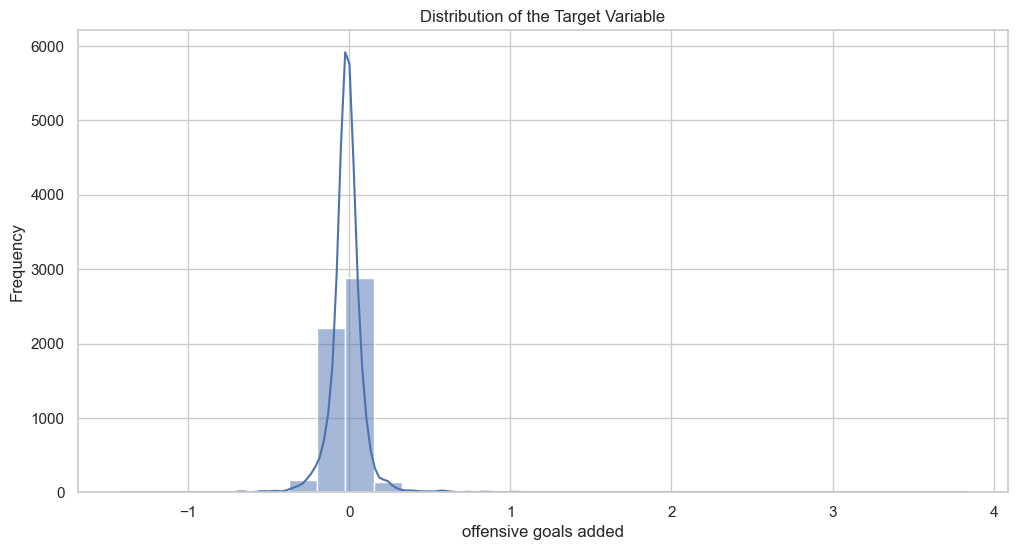

In [55]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot a histogram for the target variable
plt.figure(figsize=(12, 6))
sns.histplot(data=final_df, x='offensive_goals_added', bins=30, kde=True)
plt.title('Distribution of the Target Variable')
plt.xlabel('offensive goals added')
plt.ylabel('Frequency')
plt.show()

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


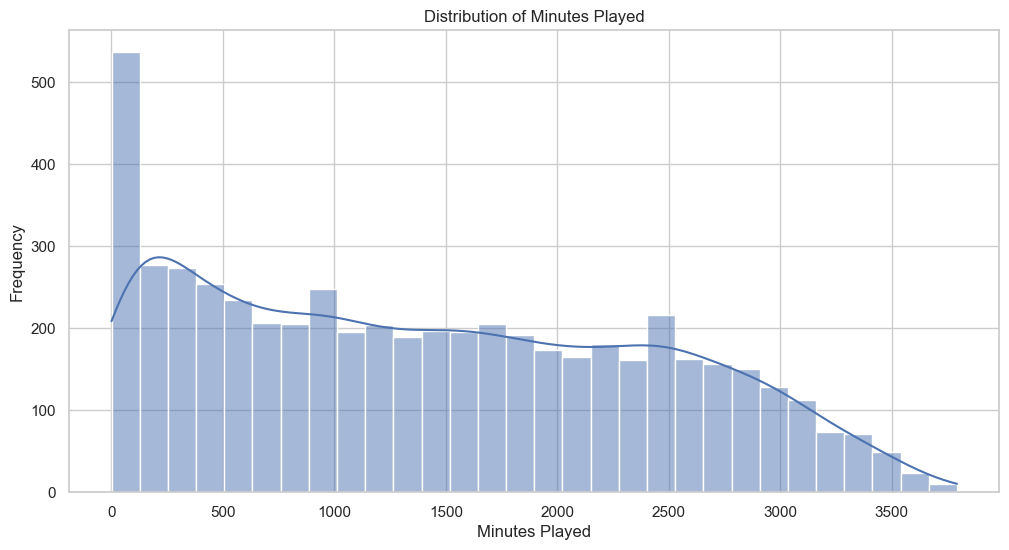

In [56]:
# Plot a histogram for minutes_played_x
plt.figure(figsize=(12, 6))
sns.histplot(data=final_df, x='minutes_played_x', bins=30, kde=True)
plt.title('Distribution of Minutes Played')
plt.xlabel('Minutes Played')
plt.ylabel('Frequency')
plt.show()

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


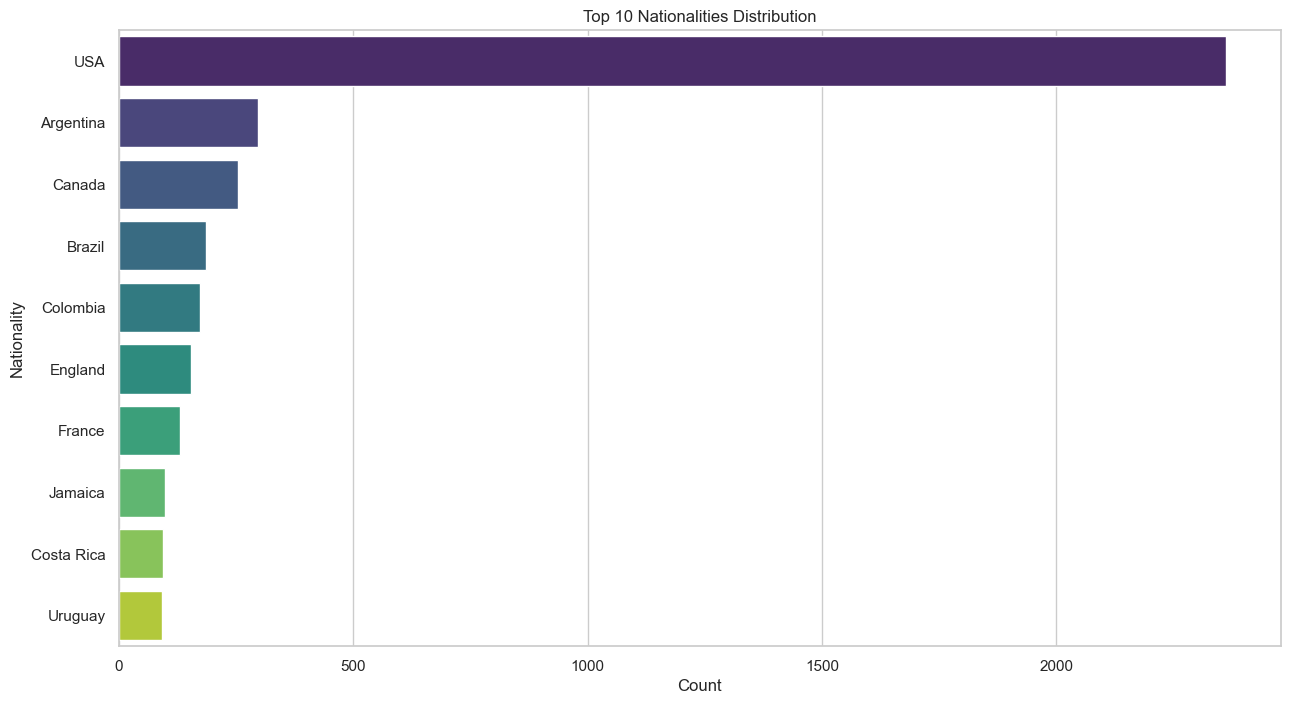

In [57]:
# Select the first 10 nationalities
top_10_nationalities = final_df['nationality'].value_counts().index[:10]

# Filter the DataFrame to include only the top 10 nationalities
filtered_df = final_df[final_df['nationality'].isin(top_10_nationalities)]

# Plot the bar plot
plt.figure(figsize=(15, 8))
sns.countplot(data=filtered_df, y='nationality', order=top_10_nationalities, palette='viridis')
plt.title('Top 10 Nationalities Distribution')
plt.xlabel('Count')
plt.ylabel('Nationality')
plt.show()

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

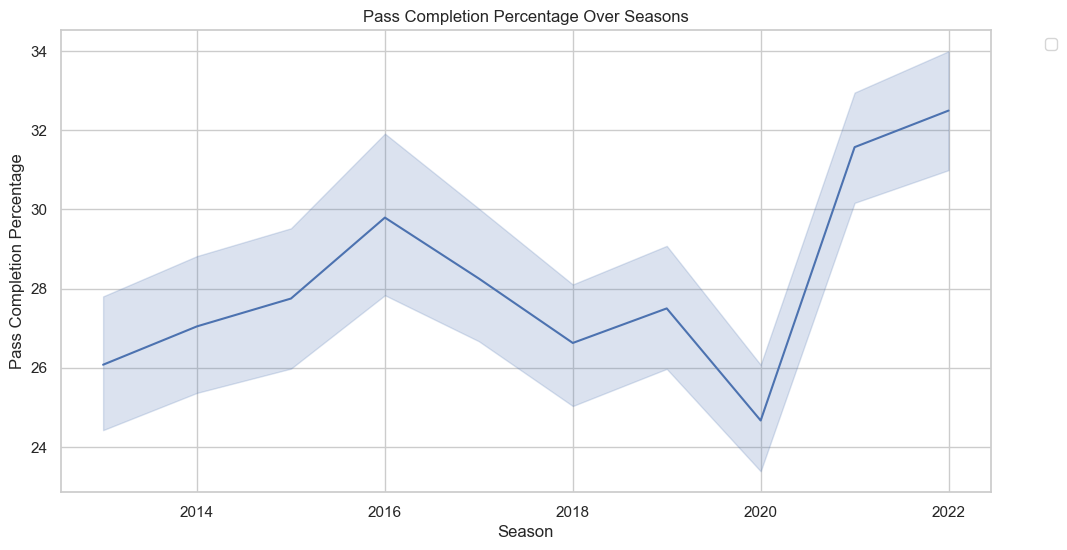

In [58]:
# Plot a line chart for pass_completion_percentage over seasons
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='season_name', y='pass_completion_percentage')
plt.title('Pass Completion Percentage Over Seasons')
plt.xlabel('Season')
plt.ylabel('Pass Completion Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


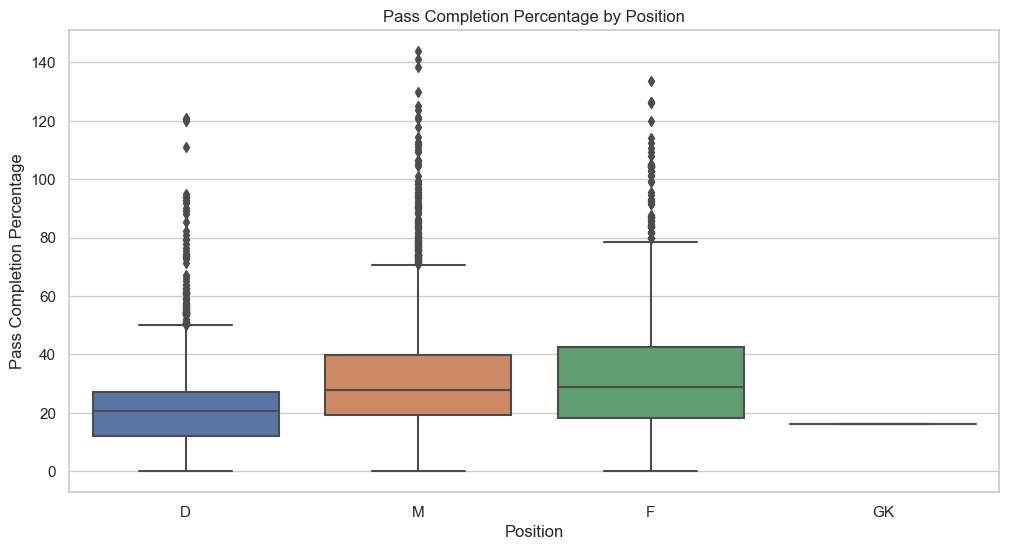

In [59]:
# Boxplot for position vs pass_completion_percentage
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df, x='position', y='pass_completion_percentage')
plt.title('Pass Completion Percentage by Position')
plt.xlabel('Position')
plt.ylabel('Pass Completion Percentage')
plt.show()

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


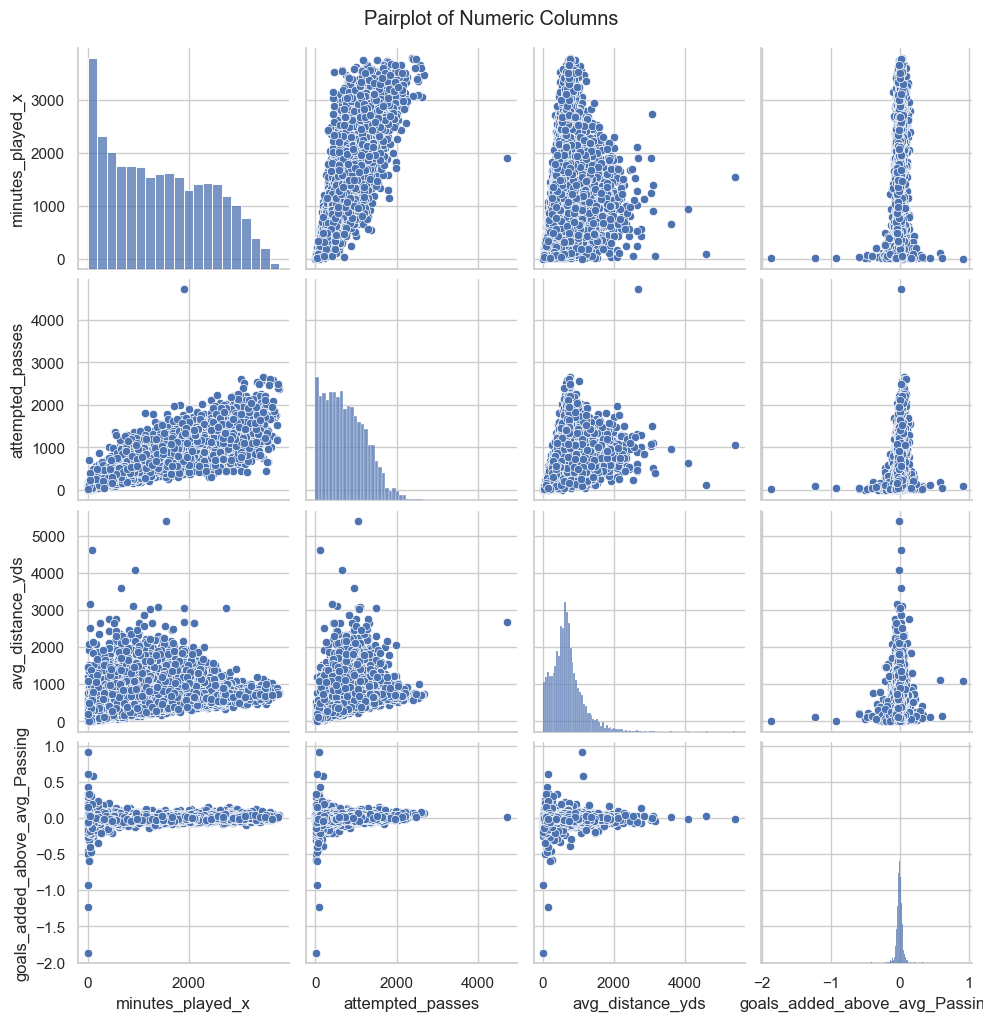

In [60]:
# Create a pairplot for selected numeric columns
numeric_cols = ['minutes_played_x', 'attempted_passes', 'avg_distance_yds', 'goals_added_above_avg_Passing']
sns.pairplot(final_df[numeric_cols])
plt.suptitle('Pairplot of Numeric Columns', y=1.02)
plt.show()

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

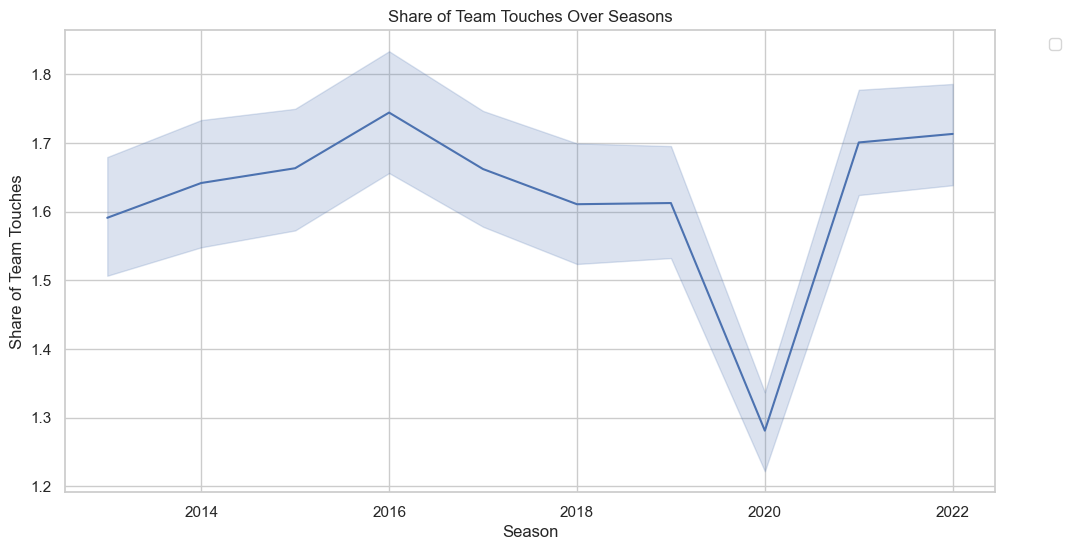

In [61]:
# Line chart for share_team_touches over seasons
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='season_name', y='share_team_touches')
plt.title('Share of Team Touches Over Seasons')
plt.xlabel('Season')
plt.ylabel('Share of Team Touches')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

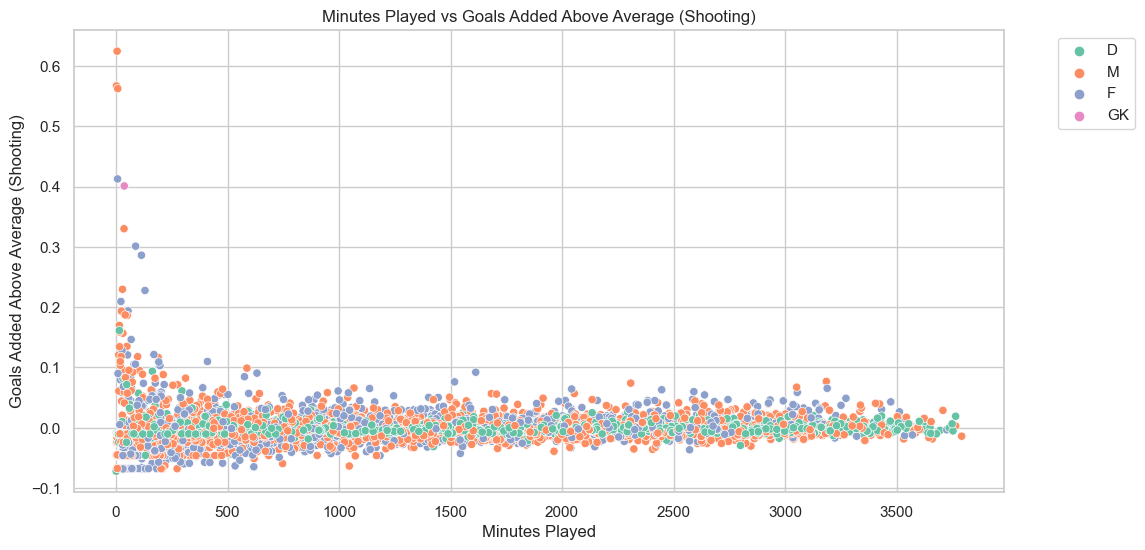

In [62]:
# Scatter plot for minutes played vs goals_added_above_avg_Shooting
plt.figure(figsize=(12, 6))
sns.scatterplot(data=final_df, x='minutes_played_x', y='goals_added_above_avg_Shooting', hue='position', palette='Set2')
plt.title('Minutes Played vs Goals Added Above Average (Shooting)')
plt.xlabel('Minutes Played')
plt.ylabel('Goals Added Above Average (Shooting)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

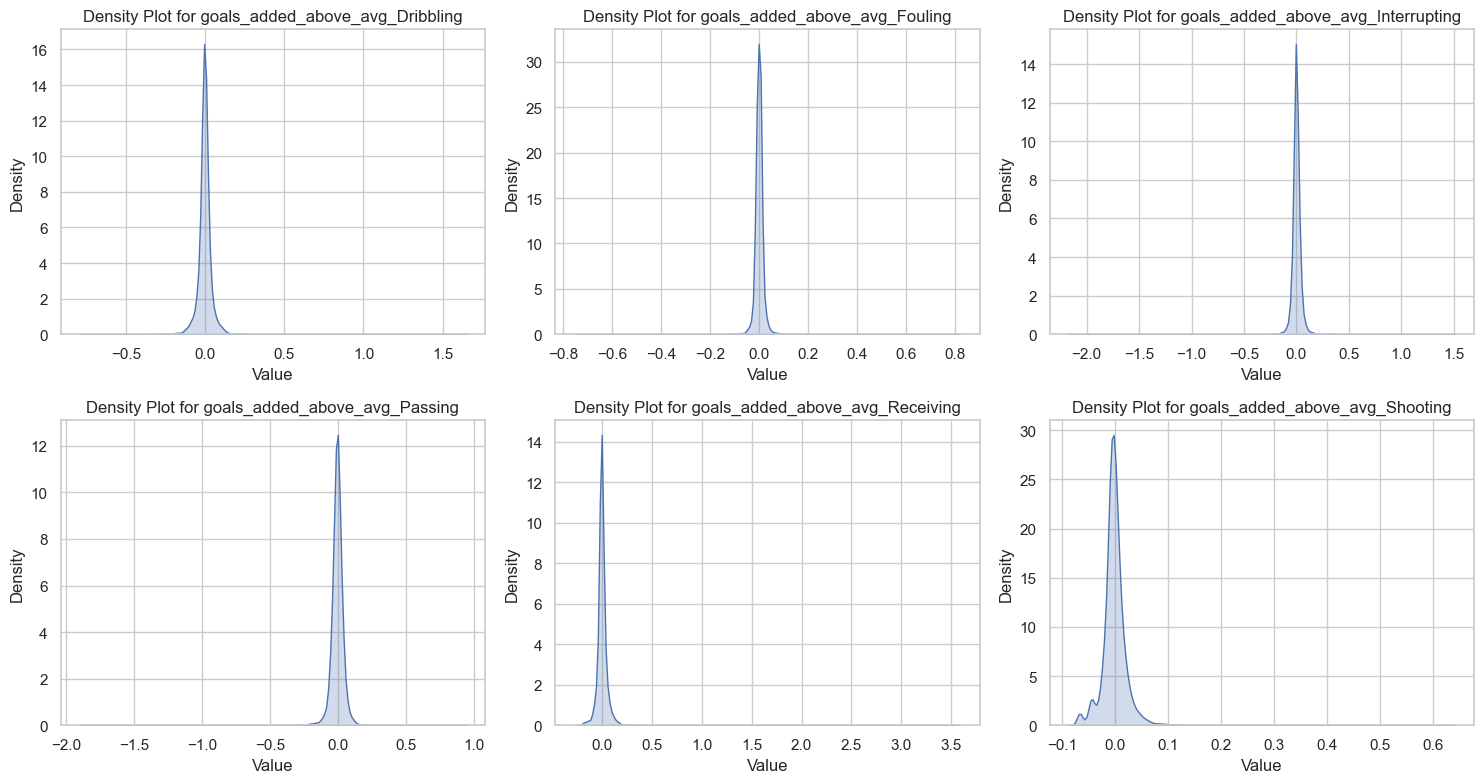

In [63]:
# Select specific variables for density plots
selected_variables = ["goals_added_above_avg_Dribbling", "goals_added_above_avg_Fouling", 
                      "goals_added_above_avg_Interrupting", "goals_added_above_avg_Passing",
                      "goals_added_above_avg_Receiving", "goals_added_above_avg_Shooting"]

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

# Create density plots for selected variables using seaborn
for i, column in enumerate(selected_variables):
    sns.kdeplot(data=final_df, x=column, ax=axes[i], fill=True)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Density Plot for {column}')

# Adjust layout
plt.tight_layout()
plt.show()

/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

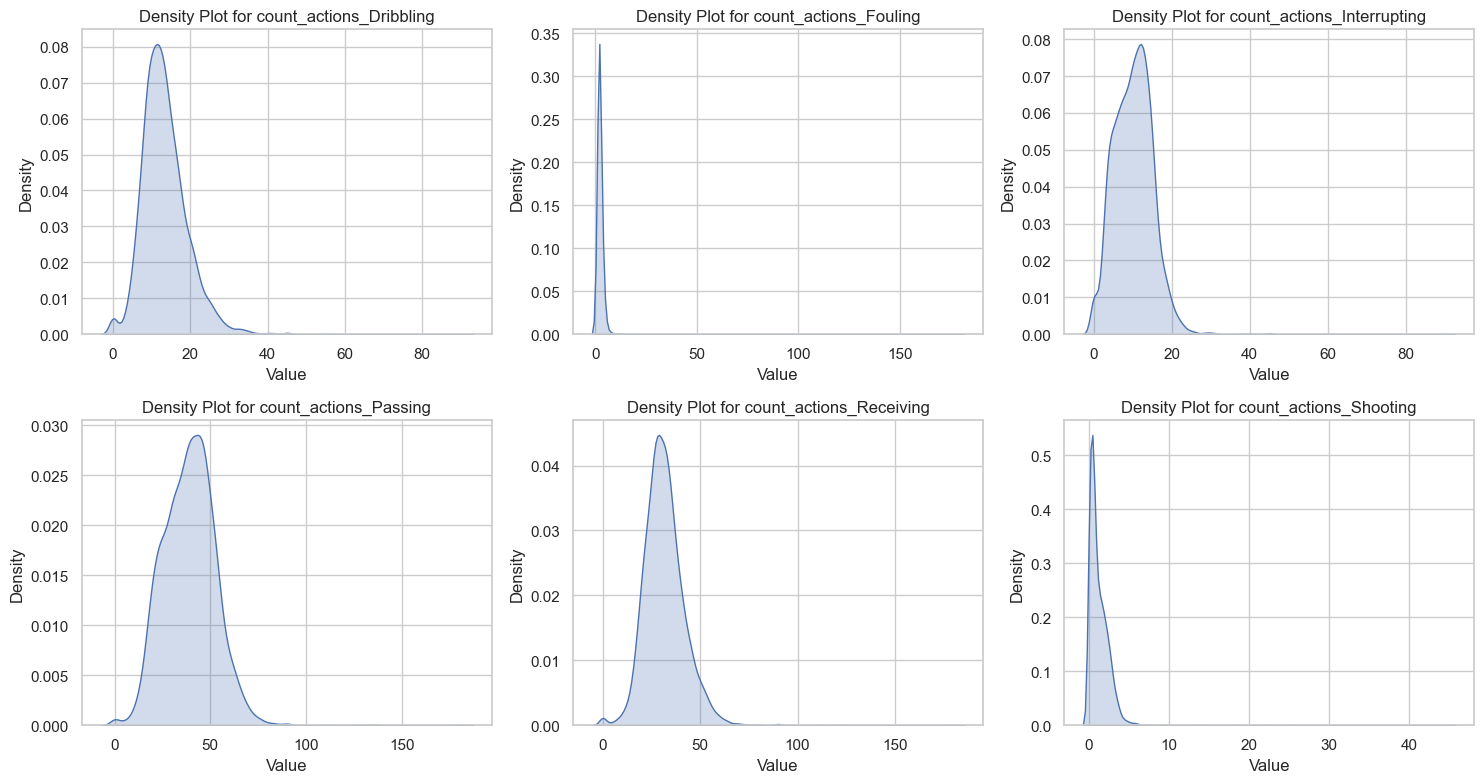

In [64]:
# Select specific variables for density plots
selected_variables = ["count_actions_Dribbling", "count_actions_Fouling", 
                      "count_actions_Interrupting", "count_actions_Passing",
                      "count_actions_Receiving", "count_actions_Shooting"]

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

# Create density plots for selected variables using seaborn
for i, column in enumerate(selected_variables):
    sns.kdeplot(data=final_df, x=column, ax=axes[i], fill=True)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Density Plot for {column}')

# Adjust layout
plt.tight_layout()
plt.show()

## Modelling

In [65]:
# Take a copy of the "final_df"
final_df_sample = final_df.copy()

In [66]:
# Variable Conversion
final_df_sample['season_name'] = final_df_sample['season_name'].astype('object')

In [67]:
# Rename column names
final_df_sample = final_df_sample.rename(columns = {'minutes_played_x':'minutes_played'})

In [68]:
final_df_sample.columns

Index(['player_id', 'season_name', 'game_id', 'team_id', 'general_position',
       'minutes_played', 'attempted_passes', 'pass_completion_percentage',
       'xpass_completion_percentage', 'passes_completed_over_expected',
       'passes_completed_over_expected_p100', 'avg_distance_yds',
       'avg_vertical_distance_yds', 'share_team_touches', 'date', 'position',
       'base_salary', 'player_name', 'birth_date', 'nationality', 'weight_lb',
       'height', 'team_name', 'team_short_name', 'team_abbreviation',
       'minutes_played_y', 'goals_added_above_avg_Dribbling',
       'goals_added_above_avg_Fouling', 'goals_added_above_avg_Interrupting',
       'goals_added_above_avg_Passing', 'goals_added_above_avg_Receiving',
       'goals_added_above_avg_Shooting', 'count_actions_Dribbling',
       'count_actions_Fouling', 'count_actions_Interrupting',
       'count_actions_Passing', 'count_actions_Receiving',
       'count_actions_Shooting', 'offensive_goals_added'],
      dtype='object'

In [69]:
# Drop Unwanted columns
final_df_sample = final_df_sample.drop(columns = ['player_id' , 'game_id' , 'team_id' ,
                                    'team_short_name' , 'team_abbreviation', 'minutes_played_y' , 'date',
                                   'player_name' , 'birth_date' , 'team_name'])
final_df_sample

,season_name,general_position,minutes_played,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,passes_completed_over_expected_p100,avg_distance_yds,avg_vertical_distance_yds,...,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting,offensive_goals_added
0,2013,CB,1817.0,494.752448,14.777021,15.426991,-11.424791,-65.000152,455.694252,200.037675,...,-0.029612,-0.020030,-0.010095,4.278607,1.094527,19.253731,25.621891,16.616915,0.000000,-0.045333
1,2014,CB,1868.0,568.804476,16.278695,15.222897,20.817656,105.569186,493.496986,251.185314,...,-0.000968,-0.018593,-0.010099,5.347966,1.493576,17.152034,29.052463,20.139186,0.000000,-0.057941
2,2015,CB,2474.0,911.467542,20.153008,19.554335,16.574477,59.874145,614.612091,283.260787,...,-0.001673,-0.011699,-0.007079,8.112369,1.782538,17.061439,34.668553,23.682296,0.109135,-0.014951
3,2016,CB,2463.0,1294.160771,44.483172,41.804545,28.731811,267.889766,1054.826648,303.133575,...,-0.008214,-0.019781,-0.010094,9.896507,1.746442,13.447607,42.729625,30.504528,0.000000,-0.046543
4,2017,CB,575.0,241.470113,10.960587,10.292968,10.632309,66.765552,302.949026,121.011916,...,-0.020123,-0.019388,-0.010111,5.226860,0.816697,13.557169,29.237750,16.987296,0.000000,-0.047499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5445,2018,ST,2677.0,740.725692,45.595605,46.274506,-20.752978,-67.858039,908.550257,108.553318,...,0.005784,0.005831,0.002862,13.005161,1.429139,2.929734,20.258039,21.687177,2.643906,0.028136
5446,2019,ST,1675.0,571.438994,56.565813,63.320739,-33.514597,-675.497349,1352.325604,-141.699992,...,0.015278,0.090572,0.017201,13.465026,1.748705,2.681347,20.168394,22.558290,3.089378,0.079753
5447,2020,W,307.0,209.964382,23.592957,23.715610,-13.759037,-12.327081,599.853652,-3.876409,...,-0.026901,-0.024132,0.022896,15.824176,0.989011,7.417582,21.263736,23.736264,3.956044,-0.032341
5448,2021,ST,329.0,52.745323,5.641514,5.706987,-2.077083,-6.541083,129.391413,-9.310200,...,-0.019368,-0.062590,-0.058869,5.471125,0.547112,3.556231,11.215805,10.395137,1.641337,-0.150620


In [70]:
# Label encoding for categorical variables
label_encoder = LabelEncoder()

categorical_columns = ['season_name','general_position','position','nationality'] 
for col in categorical_columns:
    final_df_sample[col] = label_encoder.fit_transform(final_df_sample[col])

In [71]:
final_df_sample.dtypes

season_name                              int64
general_position                         int64
minutes_played                         float64
attempted_passes                       float64
pass_completion_percentage             float64
xpass_completion_percentage            float64
passes_completed_over_expected         float64
passes_completed_over_expected_p100    float64
avg_distance_yds                       float64
avg_vertical_distance_yds              float64
share_team_touches                     float64
position                                 int64
base_salary                            float64
nationality                              int64
weight_lb                              float64
height                                 float64
goals_added_above_avg_Dribbling        float64
goals_added_above_avg_Fouling          float64
goals_added_above_avg_Interrupting     float64
goals_added_above_avg_Passing          float64
goals_added_above_avg_Receiving        float64
goals_added_a

In [72]:
final_df_sample

,season_name,general_position,minutes_played,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,passes_completed_over_expected_p100,avg_distance_yds,avg_vertical_distance_yds,...,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting,offensive_goals_added
0,0,1,1817.0,494.752448,14.777021,15.426991,-11.424791,-65.000152,455.694252,200.037675,...,-0.029612,-0.020030,-0.010095,4.278607,1.094527,19.253731,25.621891,16.616915,0.000000,-0.045333
1,1,1,1868.0,568.804476,16.278695,15.222897,20.817656,105.569186,493.496986,251.185314,...,-0.000968,-0.018593,-0.010099,5.347966,1.493576,17.152034,29.052463,20.139186,0.000000,-0.057941
2,2,1,2474.0,911.467542,20.153008,19.554335,16.574477,59.874145,614.612091,283.260787,...,-0.001673,-0.011699,-0.007079,8.112369,1.782538,17.061439,34.668553,23.682296,0.109135,-0.014951
3,3,1,2463.0,1294.160771,44.483172,41.804545,28.731811,267.889766,1054.826648,303.133575,...,-0.008214,-0.019781,-0.010094,9.896507,1.746442,13.447607,42.729625,30.504528,0.000000,-0.046543
4,4,1,575.0,241.470113,10.960587,10.292968,10.632309,66.765552,302.949026,121.011916,...,-0.020123,-0.019388,-0.010111,5.226860,0.816697,13.557169,29.237750,16.987296,0.000000,-0.047499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5445,5,5,2677.0,740.725692,45.595605,46.274506,-20.752978,-67.858039,908.550257,108.553318,...,0.005784,0.005831,0.002862,13.005161,1.429139,2.929734,20.258039,21.687177,2.643906,0.028136
5446,6,5,1675.0,571.438994,56.565813,63.320739,-33.514597,-675.497349,1352.325604,-141.699992,...,0.015278,0.090572,0.017201,13.465026,1.748705,2.681347,20.168394,22.558290,3.089378,0.079753
5447,7,6,307.0,209.964382,23.592957,23.715610,-13.759037,-12.327081,599.853652,-3.876409,...,-0.026901,-0.024132,0.022896,15.824176,0.989011,7.417582,21.263736,23.736264,3.956044,-0.032341
5448,8,5,329.0,52.745323,5.641514,5.706987,-2.077083,-6.541083,129.391413,-9.310200,...,-0.019368,-0.062590,-0.058869,5.471125,0.547112,3.556231,11.215805,10.395137,1.641337,-0.150620


In [73]:
# Filter data for training and testing
# 9 = 2022 (2022 becomes 9 because we did label encoding for the "session_name" variable)
train_data = final_df_sample[final_df_sample['season_name'] != 9]
test_data = final_df_sample[final_df_sample['season_name'] == 9]

In [74]:
train_data

,season_name,general_position,minutes_played,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,passes_completed_over_expected_p100,avg_distance_yds,avg_vertical_distance_yds,...,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting,offensive_goals_added
0,0,1,1817.0,494.752448,14.777021,15.426991,-11.424791,-65.000152,455.694252,200.037675,...,-0.029612,-0.020030,-0.010095,4.278607,1.094527,19.253731,25.621891,16.616915,0.000000,-0.045333
1,1,1,1868.0,568.804476,16.278695,15.222897,20.817656,105.569186,493.496986,251.185314,...,-0.000968,-0.018593,-0.010099,5.347966,1.493576,17.152034,29.052463,20.139186,0.000000,-0.057941
2,2,1,2474.0,911.467542,20.153008,19.554335,16.574477,59.874145,614.612091,283.260787,...,-0.001673,-0.011699,-0.007079,8.112369,1.782538,17.061439,34.668553,23.682296,0.109135,-0.014951
3,3,1,2463.0,1294.160771,44.483172,41.804545,28.731811,267.889766,1054.826648,303.133575,...,-0.008214,-0.019781,-0.010094,9.896507,1.746442,13.447607,42.729625,30.504528,0.000000,-0.046543
4,4,1,575.0,241.470113,10.960587,10.292968,10.632309,66.765552,302.949026,121.011916,...,-0.020123,-0.019388,-0.010111,5.226860,0.816697,13.557169,29.237750,16.987296,0.000000,-0.047499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5444,4,5,2073.0,921.363923,68.156996,68.345268,-31.793879,-19.003867,1811.012357,98.648147,...,-0.007421,-0.003132,-0.002009,16.140351,2.017544,4.122807,24.561404,28.070175,2.631579,0.013912
5445,5,5,2677.0,740.725692,45.595605,46.274506,-20.752978,-67.858039,908.550257,108.553318,...,0.005784,0.005831,0.002862,13.005161,1.429139,2.929734,20.258039,21.687177,2.643906,0.028136
5446,6,5,1675.0,571.438994,56.565813,63.320739,-33.514597,-675.497349,1352.325604,-141.699992,...,0.015278,0.090572,0.017201,13.465026,1.748705,2.681347,20.168394,22.558290,3.089378,0.079753
5447,7,6,307.0,209.964382,23.592957,23.715610,-13.759037,-12.327081,599.853652,-3.876409,...,-0.026901,-0.024132,0.022896,15.824176,0.989011,7.417582,21.263736,23.736264,3.956044,-0.032341


In [75]:
test_data

,season_name,general_position,minutes_played,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,passes_completed_over_expected_p100,avg_distance_yds,avg_vertical_distance_yds,...,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting,offensive_goals_added
17,9,3,1046.0,1127.704323,42.033815,40.397426,26.731138,163.766843,948.582539,263.993253,...,0.023925,-0.014002,-0.002993,12.915718,4.100228,12.095672,64.168565,52.482916,0.410023,-0.023884
21,9,0,307.0,111.255862,13.971121,17.456279,-8.858941,-348.506691,292.111185,-17.659596,...,-0.050558,-0.035053,-0.002432,13.263158,5.052632,6.315789,17.684211,18.000000,1.578947,-0.026274
25,9,1,1376.0,561.078415,9.074738,9.385483,-11.077635,-31.084069,337.978524,163.983356,...,-0.010576,0.021826,0.004520,9.680233,1.504360,15.305233,39.963663,27.340116,0.654070,0.022932
27,9,1,1523.0,1121.151314,54.192067,55.288824,-5.211804,-109.728944,1484.404769,526.135715,...,0.025171,-0.007982,-0.004242,11.375698,0.817039,11.501397,53.358939,43.994413,0.251397,0.018251
28,9,4,293.0,316.916945,14.169933,17.218175,-6.378419,-304.855297,457.665479,25.766084,...,-0.040595,-0.009824,0.010046,11.091549,3.169014,15.211268,51.654930,32.323944,0.633803,0.001014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,9,4,1489.0,951.199985,48.557885,48.676501,1.138954,-11.912520,1244.798128,-24.973917,...,-0.030182,-0.014380,-0.009948,5.562310,1.367781,8.753799,41.033435,26.808511,0.182371,-0.062590
5427,9,5,6.0,30.000000,15.000000,13.989000,2.022000,101.101500,207.580500,-146.625000,...,-0.055500,-0.193500,-0.067500,0.000000,15.000000,0.000000,30.000000,30.000000,0.000000,-0.330000
5429,9,3,1075.0,776.725226,36.367206,33.990068,-16.174571,237.651725,697.222897,228.104400,...,-0.027515,-0.016737,-0.009650,14.100817,4.536785,14.100817,45.490463,38.010899,0.858311,-0.042658
5443,9,3,438.0,502.873180,49.176869,44.756375,17.028479,442.018524,993.488817,449.524297,...,-0.013709,0.060645,-0.000837,10.988372,1.569767,8.372093,49.709302,44.476744,1.569767,0.075558


In [76]:
# Define features (X) and target variable (y)
X_train = train_data.drop(['offensive_goals_added'], axis=1)
y_train = train_data['offensive_goals_added']

X_test = test_data.drop(['offensive_goals_added'], axis=1)
y_test = test_data['offensive_goals_added']

#### Check multicolinearity

In [77]:
# Select only float64 variables as quantitative columns
num = ['float64']
num_vars = list(train_data.select_dtypes(include = num))

In [78]:
num_vars = num_vars[0:24]
num_vars

['minutes_played',
 'attempted_passes',
 'pass_completion_percentage',
 'xpass_completion_percentage',
 'passes_completed_over_expected',
 'passes_completed_over_expected_p100',
 'avg_distance_yds',
 'avg_vertical_distance_yds',
 'share_team_touches',
 'base_salary',
 'weight_lb',
 'height',
 'goals_added_above_avg_Dribbling',
 'goals_added_above_avg_Fouling',
 'goals_added_above_avg_Interrupting',
 'goals_added_above_avg_Passing',
 'goals_added_above_avg_Receiving',
 'goals_added_above_avg_Shooting',
 'count_actions_Dribbling',
 'count_actions_Fouling',
 'count_actions_Interrupting',
 'count_actions_Passing',
 'count_actions_Receiving',
 'count_actions_Shooting']

In [79]:
# Correlation matrix
corrmatrix_before = X_train[num_vars].corr()
corrmatrix_before

,minutes_played,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,passes_completed_over_expected_p100,avg_distance_yds,avg_vertical_distance_yds,share_team_touches,base_salary,...,goals_added_above_avg_Interrupting,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting
minutes_played,1.000000,0.859189,0.144482,0.135361,0.114114,0.038528,0.230050,0.242853,0.893788,0.240077,...,0.044610,0.179934,0.028994,0.102375,0.009892,-0.071937,0.096109,0.206830,0.146277,-0.001067
attempted_passes,0.859189,1.000000,0.303243,0.293220,0.216371,0.042978,0.388159,0.314913,0.970152,0.199914,...,0.049306,0.225347,-0.007967,0.064962,0.130754,-0.057949,0.153568,0.491060,0.416999,-0.069870
pass_completion_percentage,0.144482,0.303243,1.000000,0.971060,0.011305,0.124621,0.911540,0.198890,0.361067,-0.039786,...,0.054491,0.032589,0.035592,0.028698,0.122953,0.025375,-0.164083,-0.045589,0.088289,0.149647
xpass_completion_percentage,0.135361,0.293220,0.971060,1.000000,-0.108367,-0.115959,0.892122,0.140239,0.357074,-0.043548,...,0.048817,0.005861,0.031888,0.020738,0.113874,0.035951,-0.174729,-0.064953,0.063216,0.155016
passes_completed_over_expected,0.114114,0.216371,0.011305,-0.108367,1.000000,0.497210,-0.044347,0.144417,0.109396,0.041096,...,0.020836,0.128522,-0.021899,-0.017612,-0.018118,-0.073610,0.160609,0.294560,0.235427,-0.187821
passes_completed_over_expected_p100,0.038528,0.042978,0.124621,-0.115959,0.497210,1.000000,0.084677,0.244535,0.018242,0.015453,...,0.023812,0.111181,0.015547,0.033195,0.038266,-0.043813,0.043504,0.080251,0.104554,-0.021645
avg_distance_yds,0.230050,0.388159,0.911540,0.892122,-0.044347,0.084677,1.000000,0.421904,0.448233,-0.030531,...,0.049059,0.072374,0.017254,0.038311,0.086402,-0.007637,-0.070633,0.018337,0.087080,0.102268
avg_vertical_distance_yds,0.242853,0.314913,0.198890,0.140239,0.144417,0.244535,0.421904,1.000000,0.307719,-0.027682,...,0.008755,0.154871,-0.025691,0.011847,-0.112084,-0.036829,0.266133,0.205873,0.065004,-0.157177
share_team_touches,0.893788,0.970152,0.361067,0.357074,0.109396,0.018242,0.448233,0.307719,1.000000,0.192752,...,0.061243,0.216347,0.005840,0.083713,0.147417,-0.041045,0.115179,0.364758,0.320451,-0.004956
base_salary,0.240077,0.199914,-0.039786,-0.043548,0.041096,0.015453,-0.030531,-0.027682,0.192752,1.000000,...,0.010870,0.120751,0.022184,0.130003,0.152726,0.005293,-0.168412,0.063791,0.173799,0.212143


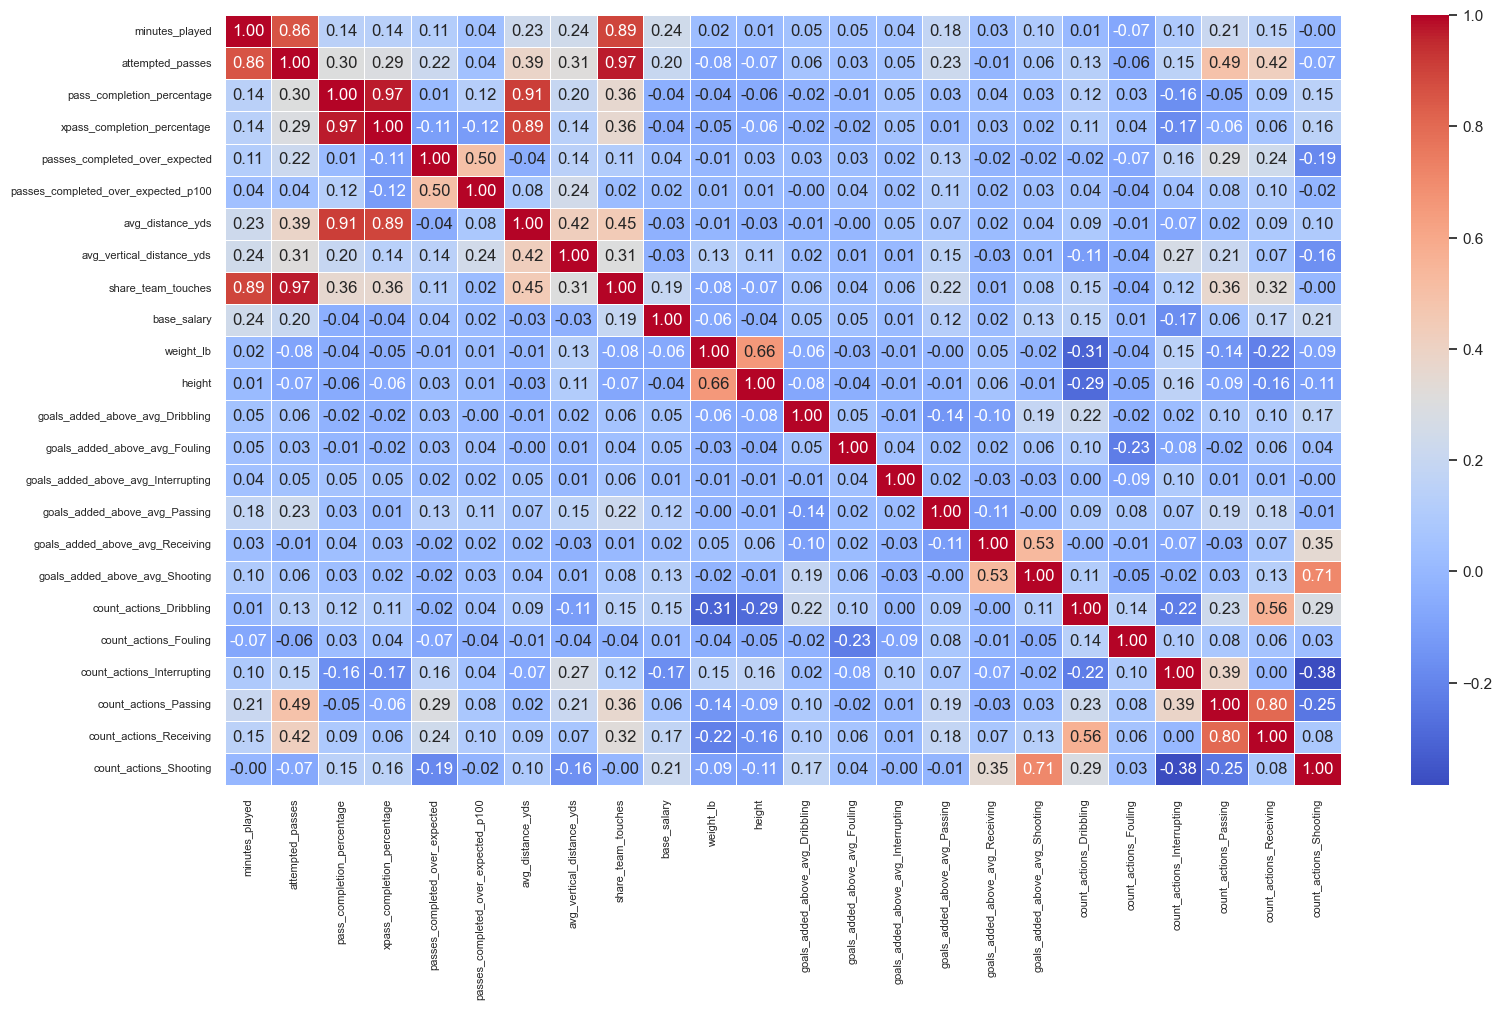

In [80]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Create a heatmap with seaborn
sns.heatmap(corrmatrix_before, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set font size for annotations
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Show the plot
plt.show()

In [81]:
# its hard for us to look into the correlation matrix
# By using below function, we can identify the variables that experiancing multicolinearity
def correlation(df, threshold):
    correlated_cols = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                correlated_cols.add(colname)
    return correlated_cols

In [82]:
# following are the variables that experiancing multicolineairty issue (more than 0.5)
corre_feature = correlation(X_train[num_vars], 0.5)
corre_feature

{'attempted_passes',
 'avg_distance_yds',
 'count_actions_Receiving',
 'count_actions_Shooting',
 'goals_added_above_avg_Shooting',
 'height',
 'share_team_touches',
 'xpass_completion_percentage'}

In [83]:
# Drop all the variables that has multicolinearity
X_train.drop(labels = corre_feature, axis = 1, inplace = True)
X_test.drop(labels = corre_feature, axis = 1, inplace = True)

#### after removing multicolineairty

In [84]:
X_train.columns

Index(['season_name', 'general_position', 'minutes_played',
       'pass_completion_percentage', 'passes_completed_over_expected',
       'passes_completed_over_expected_p100', 'avg_vertical_distance_yds',
       'position', 'base_salary', 'nationality', 'weight_lb',
       'goals_added_above_avg_Dribbling', 'goals_added_above_avg_Fouling',
       'goals_added_above_avg_Interrupting', 'goals_added_above_avg_Passing',
       'goals_added_above_avg_Receiving', 'count_actions_Dribbling',
       'count_actions_Fouling', 'count_actions_Interrupting',
       'count_actions_Passing'],
      dtype='object')

In [85]:
num_vars_new = ['minutes_played',
       'pass_completion_percentage', 'passes_completed_over_expected',
       'passes_completed_over_expected_p100', 'avg_vertical_distance_yds',
       'base_salary','weight_lb',
       'goals_added_above_avg_Dribbling', 'goals_added_above_avg_Fouling',
       'goals_added_above_avg_Interrupting', 'goals_added_above_avg_Passing',
       'goals_added_above_avg_Receiving', 'count_actions_Dribbling',
       'count_actions_Fouling', 'count_actions_Interrupting',
       'count_actions_Passing']

In [86]:
# Correlation matrix
corrmatrix_after = X_train[num_vars_new].corr()
corrmatrix_after

,minutes_played,pass_completion_percentage,passes_completed_over_expected,passes_completed_over_expected_p100,avg_vertical_distance_yds,base_salary,weight_lb,goals_added_above_avg_Dribbling,goals_added_above_avg_Fouling,goals_added_above_avg_Interrupting,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing
minutes_played,1.000000,0.144482,0.114114,0.038528,0.242853,0.240077,0.022858,0.049678,0.046140,0.044610,0.179934,0.028994,0.009892,-0.071937,0.096109,0.206830
pass_completion_percentage,0.144482,1.000000,0.011305,0.124621,0.198890,-0.039786,-0.044303,-0.024170,-0.008118,0.054491,0.032589,0.035592,0.122953,0.025375,-0.164083,-0.045589
passes_completed_over_expected,0.114114,0.011305,1.000000,0.497210,0.144417,0.041096,-0.005463,0.030943,0.030838,0.020836,0.128522,-0.021899,-0.018118,-0.073610,0.160609,0.294560
passes_completed_over_expected_p100,0.038528,0.124621,0.497210,1.000000,0.244535,0.015453,0.011229,-0.000156,0.038221,0.023812,0.111181,0.015547,0.038266,-0.043813,0.043504,0.080251
avg_vertical_distance_yds,0.242853,0.198890,0.144417,0.244535,1.000000,-0.027682,0.129657,0.024152,0.008229,0.008755,0.154871,-0.025691,-0.112084,-0.036829,0.266133,0.205873
base_salary,0.240077,-0.039786,0.041096,0.015453,-0.027682,1.000000,-0.062150,0.049489,0.045476,0.010870,0.120751,0.022184,0.152726,0.005293,-0.168412,0.063791
weight_lb,0.022858,-0.044303,-0.005463,0.011229,0.129657,-0.062150,1.000000,-0.063032,-0.026674,-0.014105,-0.003478,0.047468,-0.309181,-0.040947,0.146931,-0.142072
goals_added_above_avg_Dribbling,0.049678,-0.024170,0.030943,-0.000156,0.024152,0.049489,-0.063032,1.000000,0.053087,-0.008637,-0.138853,-0.102739,0.219297,-0.024048,0.021974,0.100572
goals_added_above_avg_Fouling,0.046140,-0.008118,0.030838,0.038221,0.008229,0.045476,-0.026674,0.053087,1.000000,0.038839,0.016970,0.020589,0.103698,-0.225386,-0.076353,-0.024123
goals_added_above_avg_Interrupting,0.044610,0.054491,0.020836,0.023812,0.008755,0.010870,-0.014105,-0.008637,0.038839,1.000000,0.017104,-0.028126,0.001684,-0.086285,0.100974,0.005619


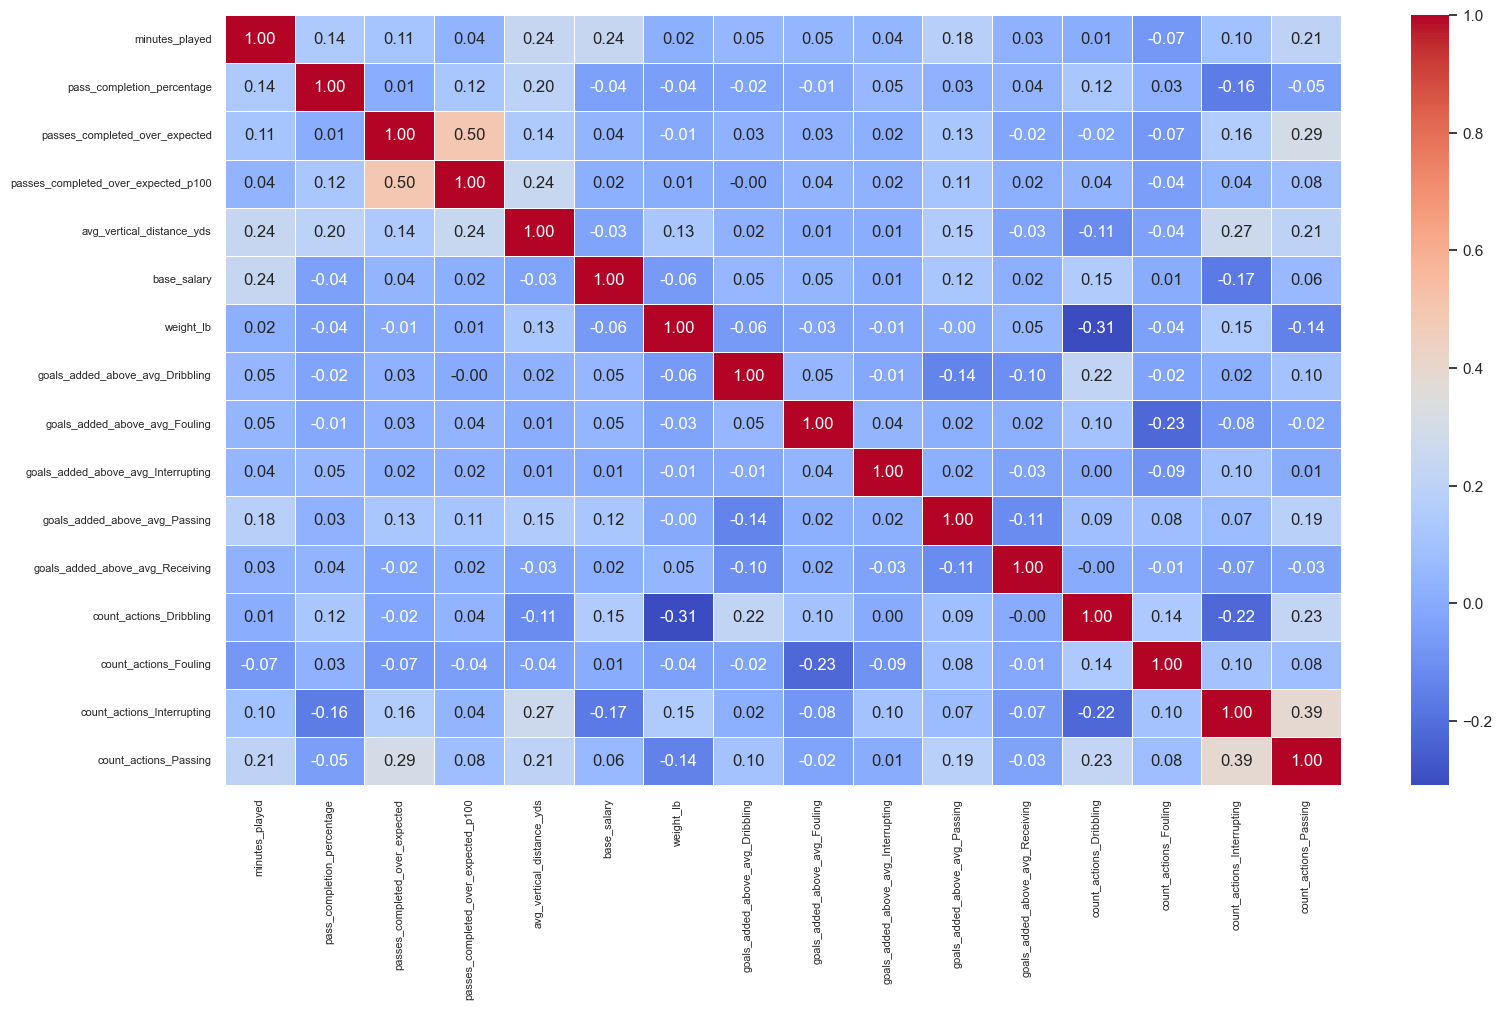

In [87]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Create a heatmap with seaborn
sns.heatmap(corrmatrix_after, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set font size for annotations
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Show the plot
plt.show()

In [88]:
X_train.shape

(4812, 20)

In [89]:
X_test.shape

(637, 20)

### 01) Random Forest Regressor

In [90]:
# Random and Grid Search models
random_search_model = RandomForestRegressor(random_state=42)
grid_search_model = RandomForestRegressor(random_state=42)

In [91]:
# Cross Valaidation
cv_split = KFold(n_splits=5, random_state=42, shuffle=True)

In [92]:
# Hyper parameter Grid
rf_hyperparam_grid={
    'n_estimators': [25, 50],
    'bootstrap': [True]
}

In [93]:
rf_random_search=RandomizedSearchCV(
    estimator=random_search_model,
    param_distributions=rf_hyperparam_grid,
    scoring="neg_log_loss",
    refit=True,
    return_train_score=True,
    cv=cv_split,    
    verbose=10,
    n_jobs=-1,
    random_state=42
)

In [94]:
# Tuned Model
tuned_random_model_rf = rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    y_pred = method_caller(clf, "predict_proba", X, pos_label=self._get_pos_label())
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [95]:
# Best Parameters
tuned_random_model_rf.best_params_

{'n_estimators': 25, 'bootstrap': True}

In [96]:
# Random Forest model with Best Parameters
model_rf = RandomForestRegressor(random_state=42, n_estimators = 25, bootstrap = True)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=25, random_state=42)

In [97]:
# Make predictions on the test set
predictions_rf = model_rf.predict(X_test)

In [98]:
# Evaluate the model (for example, using mean squared error)
mse = mean_squared_error(y_test, predictions_rf)
print(f'Mean Squared Error on the test set: {mse}')

# Evaluate the model using R-squared
r2 = r2_score(y_test, predictions_rf)
print(f'R-squared on the test set: {r2}')

Mean Squared Error on the test set: 0.0019743738253927214
R-squared on the test set: 0.7382838744666769


/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


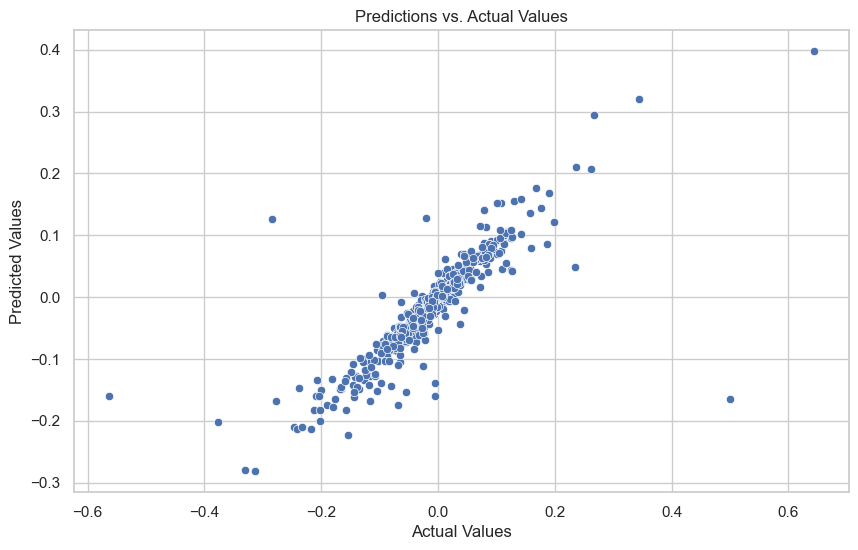

In [99]:
# Visualize the predictions vs. actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions_rf)
plt.title('Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

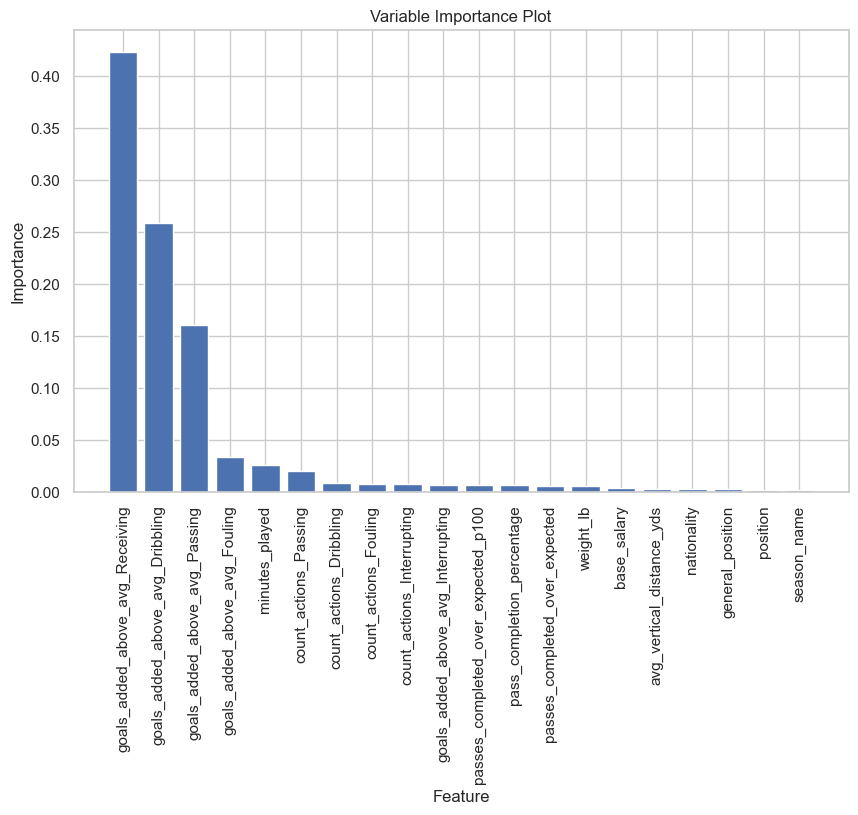

In [100]:
# Get feature importances from the trained model
feature_importances = model_rf.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Sort feature importances in descending order
indices = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Variable Importance Plot")
plt.show()

In [101]:
# Create a DataFrame with actual and predicted values
prediction_df_rf = pd.DataFrame({'offensive_goals_added': y_test, 'Predicted_for_2022': predictions_rf})
prediction_df_rf

,offensive_goals_added,Predicted_for_2022
17,-0.023884,-0.009919
21,-0.026274,-0.111397
25,0.022932,0.027509
27,0.018251,0.019735
28,0.001014,-0.014085
...,...,...
5409,-0.062590,-0.064806
5427,-0.330000,-0.279812
5429,-0.042658,-0.046722
5443,0.075558,0.081438


In [102]:
subset_df_2022 = final_df[final_df['season_name'] == 2022]
subset_df_2022

,player_id,season_name,game_id,team_id,general_position,minutes_played_x,attempted_passes,pass_completion_percentage,xpass_completion_percentage,passes_completed_over_expected,...,goals_added_above_avg_Passing,goals_added_above_avg_Receiving,goals_added_above_avg_Shooting,count_actions_Dribbling,count_actions_Fouling,count_actions_Interrupting,count_actions_Passing,count_actions_Receiving,count_actions_Shooting,offensive_goals_added
17,0Oq632k7Q6,2022,0Oq6OArxQ6,jYQJ19EqGR,DM,1046.0,1127.704323,42.033815,40.397426,26.731138,...,0.023925,-0.014002,-0.002993,12.915718,4.100228,12.095672,64.168565,52.482916,0.410023,-0.023884
21,0Oq633dAQ6,2022,0x5gg9dZ57,EKXMeX3Q64,AM,307.0,111.255862,13.971121,17.456279,-8.858941,...,-0.050558,-0.035053,-0.002432,13.263158,5.052632,6.315789,17.684211,18.000000,1.578947,-0.026274
25,0Oq63JA7Q6,2022,9vQ2WA61MK,X0Oq66zq6D,CB,1376.0,561.078415,9.074738,9.385483,-11.077635,...,-0.010576,0.021826,0.004520,9.680233,1.504360,15.305233,39.963663,27.340116,0.654070,0.022932
27,0Oq63P32Q6,2022,0Oq6OARXQ6,mKAqBBmqbg,CB,1523.0,1121.151314,54.192067,55.288824,-5.211804,...,0.025171,-0.007982,-0.004242,11.375698,0.817039,11.501397,53.358939,43.994413,0.251397,0.018251
28,0Oq63Ym2Q6,2022,2lqRox4JQr,19vQ2095K6,FB,293.0,316.916945,14.169933,17.218175,-6.378419,...,-0.040595,-0.009824,0.010046,11.091549,3.169014,15.211268,51.654930,32.323944,0.633803,0.001014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,zeQZJxR1QK,2022,4JMA7E92qK,vzqoOgNqap,FB,1489.0,951.199985,48.557885,48.676501,1.138954,...,-0.030182,-0.014380,-0.009948,5.562310,1.367781,8.753799,41.033435,26.808511,0.182371,-0.062590
5427,zeQZXXm15K,2022,4wM4GAnzQj,Z2vQ1xlqrA,ST,6.0,30.000000,15.000000,13.989000,2.022000,...,-0.055500,-0.193500,-0.067500,0.000000,15.000000,0.000000,30.000000,30.000000,0.000000,-0.330000
5429,zeQZXr4g5K,2022,0Oq6OANXQ6,KAqBN0Vqbg,DM,1075.0,776.725226,36.367206,33.990068,-16.174571,...,-0.027515,-0.016737,-0.009650,14.100817,4.536785,14.100817,45.490463,38.010899,0.858311,-0.042658
5443,zeQZjOPjQK,2022,2vQ1BmaOMr,kaDQ0wRqEv,DM,438.0,502.873180,49.176869,44.756375,17.028479,...,-0.013709,0.060645,-0.000837,10.988372,1.569767,8.372093,49.709302,44.476744,1.569767,0.075558


In [103]:
# Final predictive dataset (here, we have only the players that play for the year 2022)
predictive_df_rf = pd.merge(subset_df_2022,prediction_df_rf, on = "offensive_goals_added" , how = "inner" )
predictive_df_rf = predictive_df_rf[["player_id", "player_name", "season_name", 
                              "offensive_goals_added", "Predicted_for_2022"]]
predictive_df_rf

,player_id,player_name,season_name,offensive_goals_added,Predicted_for_2022
0,0Oq632k7Q6,Danny Leyva,2022,-0.023884,-0.009919
1,0Oq633dAQ6,Griffin Yow,2022,-0.026274,-0.111397
2,0Oq63JA7Q6,Wyatt Omsberg,2022,0.022932,0.027509
3,0Oq63P32Q6,Nkosi Burgess,2022,0.018251,0.019735
4,0Oq63Ym2Q6,Ryan Spaulding,2022,0.001014,-0.014085
...,...,...,...,...,...
658,zeQZJxR1QK,Eric Miller,2022,-0.062590,-0.064806
659,zeQZXXm15K,Jacob Davis,2022,-0.330000,-0.279812
660,zeQZXr4g5K,Franco Ibarra,2022,-0.042658,-0.046722
661,zeQZjOPjQK,Daniel Aguirre,2022,0.075558,0.081438


### 02) XGBoost Regressor

In [104]:
# Random and Grid Search models
random_search_model = XGBRegressor(random_state=42)
grid_search_model = XGBRegressor(random_state=42)

In [105]:
# Hyper parameter Grid
xgb_hyperparam_grid={
    'depth': [3, 6],
    'subsample': [0.5, 0.6]
}

In [106]:
xgb_random_search=RandomizedSearchCV(
    estimator=random_search_model,
    param_distributions=xgb_hyperparam_grid,
    scoring="neg_log_loss",
    refit=True,
    return_train_score=True,
    cv=cv_split,    
    verbose=10,
    n_jobs=-1,
    random_state=42
)

In [107]:
# Tuned Model
tuned_random_model_xgb = xgb_random_search.fit(X_train, y_train)

/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/thilina/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thilina/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thilina/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thilina/anaconda3/lib/python3.1

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/thilina/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/U

/Users/thilina/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:06:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/U

/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thilina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    y_pred = method_caller(clf, "predict_proba", X, pos_label=self._get_pos_label())
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [108]:
# Best Parameters
tuned_random_model_xgb.best_params_

{'subsample': 0.5, 'depth': 3}

In [109]:
# Initialize and train the XGBoost model
model_xgb = XGBRegressor(random_state=42, depth = 3, subsample = 0.5)
model_xgb.fit(X_train, y_train)

# Make predictions on the test set
predictions_xgb = model_xgb.predict(X_test)

# Evaluate the XGBoost model (for example, using mean squared error)
mse_xgb = mean_squared_error(y_test, predictions_xgb)
print(f'Mean Squared Error on the test set (XGBoost): {mse_xgb}')

# Evaluate the model using R-squared
r2 = r2_score(y_test, predictions_xgb)
print(f'R-squared on the test set: {r2}')

/Users/thilina/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:06:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "depth" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error on the test set (XGBoost): 0.001855142736179539
R-squared on the test set: 0.7540887328529984


/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thilina/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


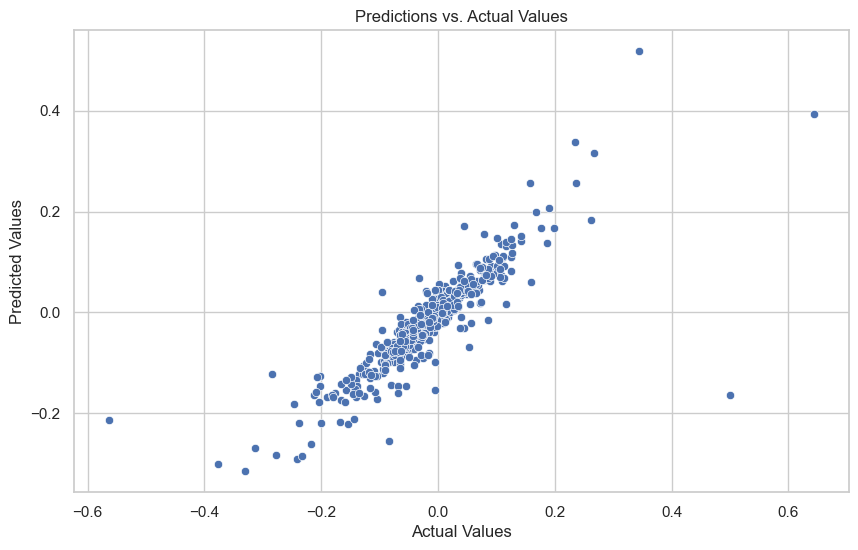

In [110]:
# Visualize the predictions vs. actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions_xgb)
plt.title('Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

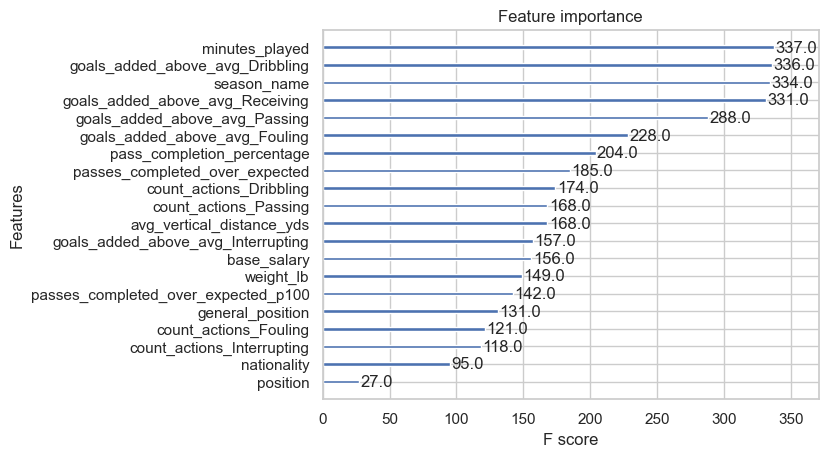

In [111]:
# Plot Variable Importance
plot_importance(model_xgb)
plt.show()

In [112]:
# Create a DataFrame with actual and predicted values
prediction_df_xgb = pd.DataFrame({'offensive_goals_added': y_test, 'Predicted_for_2022': predictions_xgb})
prediction_df_xgb

,offensive_goals_added,Predicted_for_2022
17,-0.023884,-0.021020
21,-0.026274,-0.090018
25,0.022932,0.035719
27,0.018251,0.016904
28,0.001014,0.005483
...,...,...
5409,-0.062590,-0.076476
5427,-0.330000,-0.315401
5429,-0.042658,-0.034237
5443,0.075558,0.089397


In [113]:
# Final predictive dataset (here, we have only the players that play for the year 2022)
predictive_df_xgb = pd.merge(subset_df_2022,prediction_df_xgb, on = "offensive_goals_added" , how = "inner" )
predictive_df_xgb = predictive_df_xgb[["player_id", "player_name", "season_name", 
                              "offensive_goals_added", "Predicted_for_2022"]]
predictive_df_xgb

,player_id,player_name,season_name,offensive_goals_added,Predicted_for_2022
0,0Oq632k7Q6,Danny Leyva,2022,-0.023884,-0.021020
1,0Oq633dAQ6,Griffin Yow,2022,-0.026274,-0.090018
2,0Oq63JA7Q6,Wyatt Omsberg,2022,0.022932,0.035719
3,0Oq63P32Q6,Nkosi Burgess,2022,0.018251,0.016904
4,0Oq63Ym2Q6,Ryan Spaulding,2022,0.001014,0.005483
...,...,...,...,...,...
658,zeQZJxR1QK,Eric Miller,2022,-0.062590,-0.076476
659,zeQZXXm15K,Jacob Davis,2022,-0.330000,-0.315401
660,zeQZXr4g5K,Franco Ibarra,2022,-0.042658,-0.034237
661,zeQZjOPjQK,Daniel Aguirre,2022,0.075558,0.089397


In [114]:
sorted_df = predictive_df_xgb.sort_values(by='Predicted_for_2022', ascending=False)
sorted_df

,player_id,player_name,season_name,offensive_goals_added,Predicted_for_2022
414,e7MzZ63OMr,Bernard Kamungo,2022,0.343385,0.518010
528,jYQJzmgEQG,Alexandru Matan,2022,0.643114,0.393380
120,7vQ7Bvx8qD,Christopher Garcia,2022,0.235000,0.337740
195,KAqB49JMbg,Gareth Bale,2022,0.267061,0.315545
450,eVq3xb9XQW,Daniel Trejo,2022,0.158143,0.257303
...,...,...,...,...,...
320,OlMleyrD5L,Matías Pellegrini,2022,-0.277412,-0.283551
525,jYQJgJvdMG,Koa Santos,2022,-0.232839,-0.284497
270,NWMWL3XK5l,Aké Arnaud Loba,2022,-0.241738,-0.291180
210,KAqBNnrVqb,Jesús Bueno,2022,-0.376875,-0.300793
